In [1]:
# Import relevant packages
import uproot
import vector
import awkward as ak
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import math
import matplotlib.colors as colors
from scipy.stats import norm

In [2]:
f=uproot.open("/Users/isaac/Desktop/mucolstudies/ntup_collectionsNoBIB.root")

In [3]:
print(f.keys())

['tracks_tree;1']


In [4]:
tree=f["tracks_tree"]
treeBIB=uproot.open("/Users/isaac/Desktop/mucolstudies/ntup_hitsBIB1[123]0.root")["tracks_tree"]

In [5]:
print(tree.keys())

['x', 'y', 'z', 't', 'barOrEnd', 'location', 'module', 'layer', 'side']


In [6]:
# a handy plotting function
def plot1DHistogram(data,bins,scale='linear',label="", savefig=False, dpi=300):
    
    # handle data, there must be a smarter way to do this...
    if type(data[0])==np.int64 : data_flat=data
    elif type(data[0])==np.float32 : data_flat=data
    elif type(data[0])==np.float64 : data_flat=data
    else: data_flat = ak.flatten(data)
    
    fig = plt.figure(figsize=(15,10))
    ax = fig.add_subplot(111)
    
    ax.hist(data_flat, bins=bins)
    
    # handle labels
    title  = "" if len(label.split(";")) < 1 else label.split(";")[0]  
    xlabel = "" if len(label.split(";")) < 2 else label.split(";")[1]  
    ylabel = "" if len(label.split(";")) < 3 else label.split(";")[2] 
    
    ax.set_title(title)
    ax.set_xlabel(xlabel, fontsize=15)
    ax.set_ylabel(ylabel, fontsize=15)
    plt.yscale(scale)
    if savefig:
        plt.savefig(title + ".png", dpi=dpi)
    plt.show()

In [7]:
# a handy plotting function
def plot2DHistogram(datax, datay, bins=100, norm="log", label="", savefig=False, dpi=300):
    
    data_flatx = np.array(np.ravel(datax)).T
    data_flaty = np.array(np.ravel(datay)).T
    #print(len(data_flatx),data_flatx)
    #print(len(data_flaty),data_flaty)
    
    fig = plt.figure(figsize=(15,10))
    ax = fig.add_subplot(111)
    
    hh = ax.hist2d(data_flatx, data_flaty, bins=bins, norm=norm, cmap="plasma")
    
    title  = "" if len(label.split(";")) < 1 else label.split(";")[0]  
    xlabel = "" if len(label.split(";")) < 2 else label.split(";")[1]  
    ylabel = "" if len(label.split(";")) < 3 else label.split(";")[2]  
    zlabel = "" if len(label.split(";")) < 4 else label.split(";")[3] 
    
    ax.set_title(title)
    ax.set_xlabel(xlabel, fontsize=15)
    ax.set_ylabel(ylabel, fontsize=15)
    
    # colorbars are annoying
    cbar = fig.colorbar(hh[3])
    #cbar.ax.tick_params(labelsize=tick_font_size)
    cbar.set_label(zlabel, fontsize=15)

    if savefig:
        plt.savefig(title + ".png", dpi=dpi)
    plt.show()

In [8]:
plt.style.use('seaborn-v0_8-colorblind')
plt.rcParams.update({'font.size': 20})
plt.rcParams.update({'xtick.major.size' : 10}) 
plt.rcParams.update({'ytick.major.size' : 10}) 
plt.rcParams.update({'xtick.minor.size' : 5}) 
plt.rcParams.update({'ytick.minor.size' : 5}) 
plt.rcParams.update({'axes.labelsize' : "large"}) 

# Investigating the meaning of our different keys

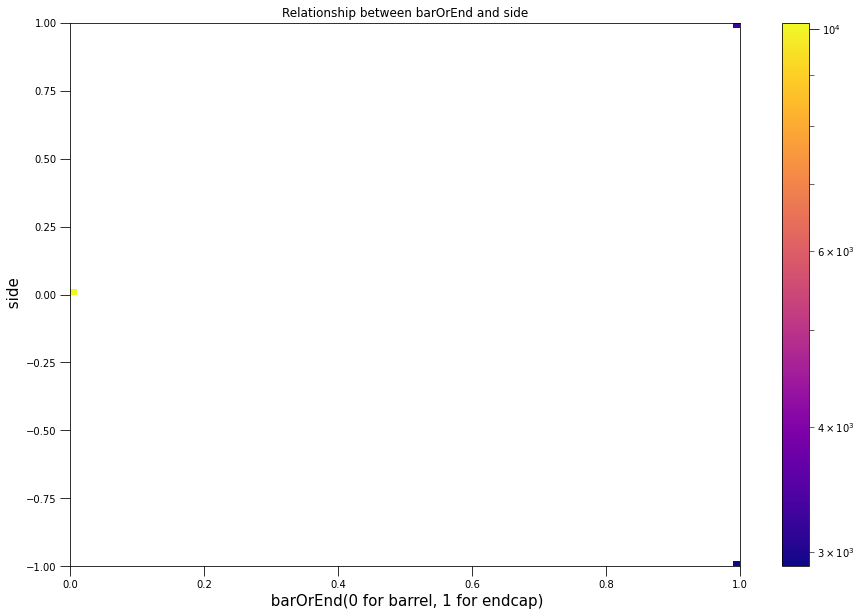

In [9]:
plot2DHistogram(tree["barOrEnd"].array(), tree["side"].array(), label=("Relationship between barOrEnd and side; barOrEnd(0 for barrel, 1 for endcap); side"))

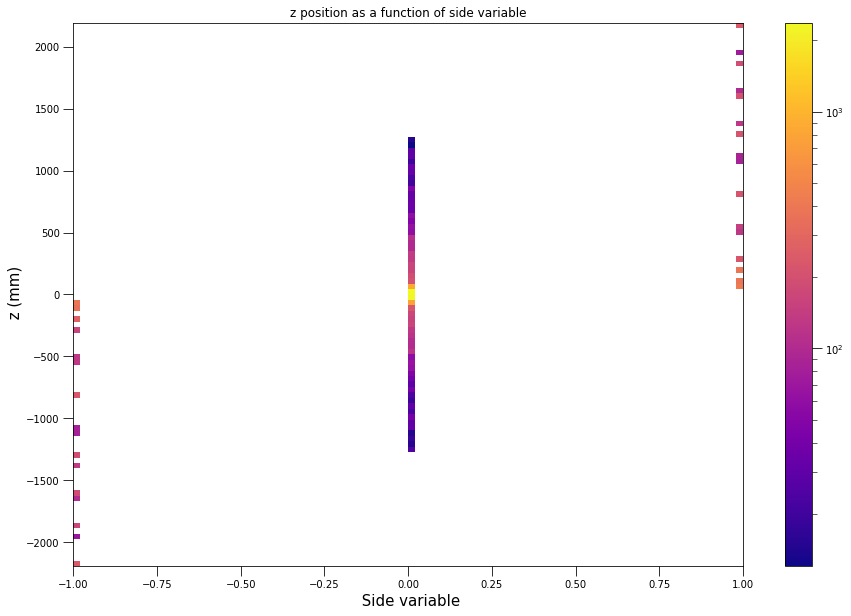

In [10]:
plot2DHistogram(tree["side"], tree["z"], label="z position as a function of side variable; Side variable; z (mm)")

#### barOrEnd was coded to be a 0 if reading a collection that was named "\*BarrelCollection" and a 1 if reading "\*EndcapCollection". Therefore the top graph shows side=0 is equivilent to the hit being in the barrel, while side=1,-1 is equivilent to the hit being on the endcap.
#### The second graph shows that side=1 marks all the hits on endcaps with a positive z and side=-1 marks all the hits on endcaps with a negative z

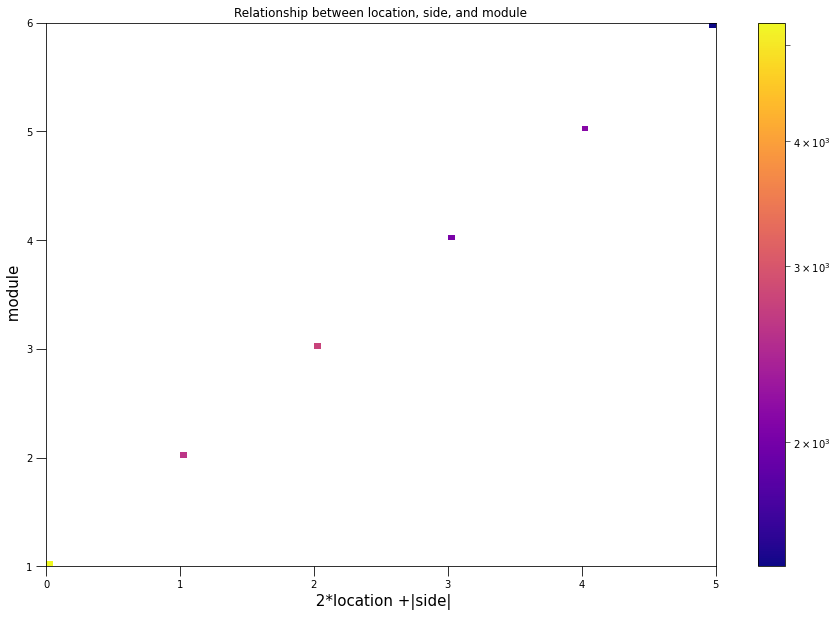

In [11]:
plot2DHistogram(2*tree["location"].array()+np.abs(tree["side"].array()), tree["module"].array(), label="Relationship between location, side, and module; 2*location +|side|; module")

#### I coded location to read 0 if the hit was in the vertex, 1 if the hit was in the inner detector and 2 if the hit was in the outer detector. The above graph shows that module uniquely determines both the detector and if its on the barrel or endcap by assigning each hit 2 times my value for location and then adding 1 if its on the barrel and 2 if its on an endcap.

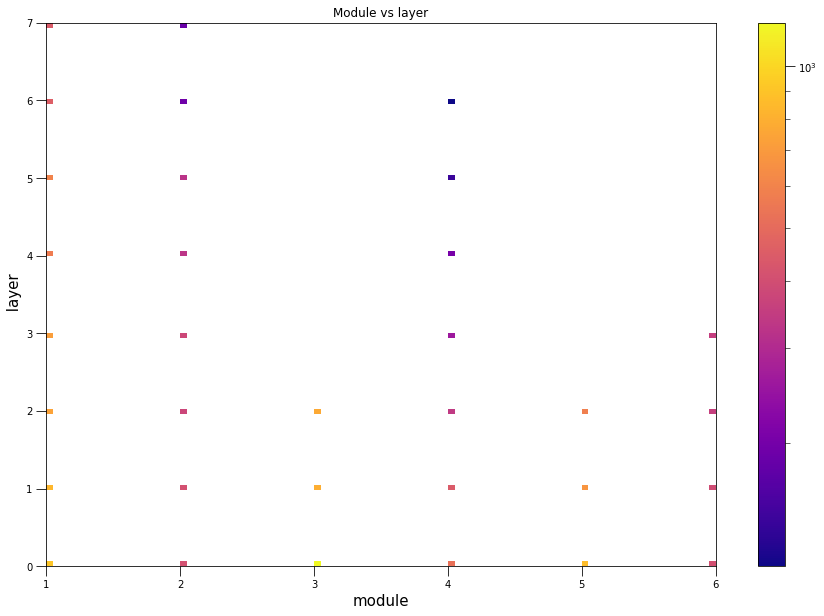

In [12]:
plot2DHistogram(tree["module"].array(),tree["layer"].array(), label="Module vs layer;module; layer")

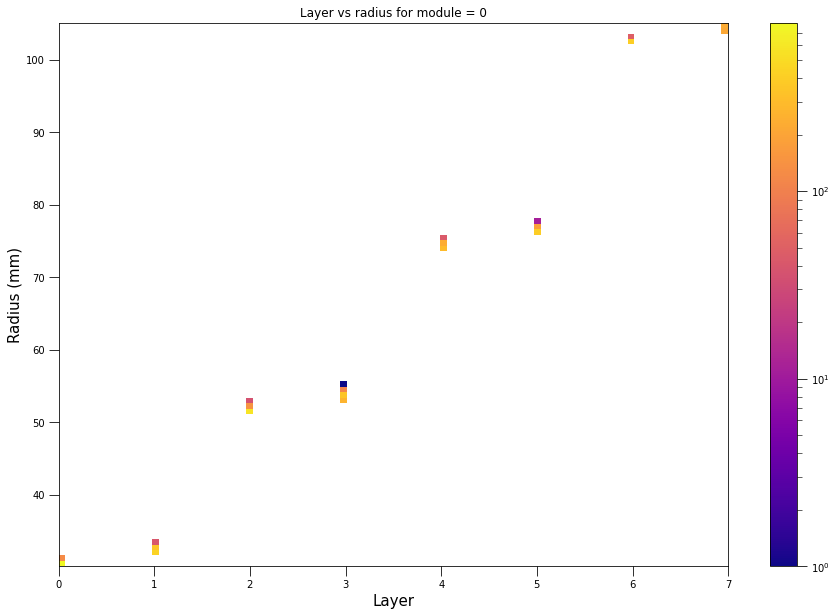

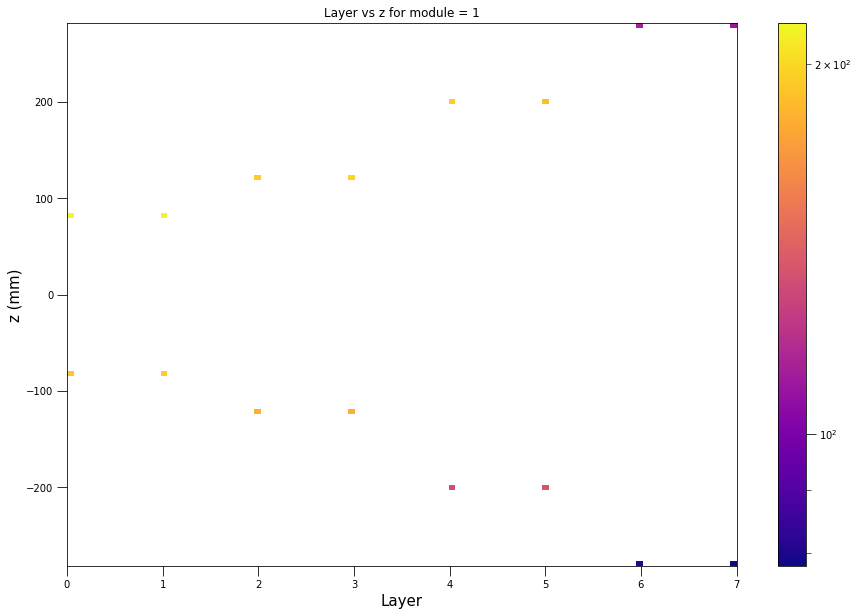

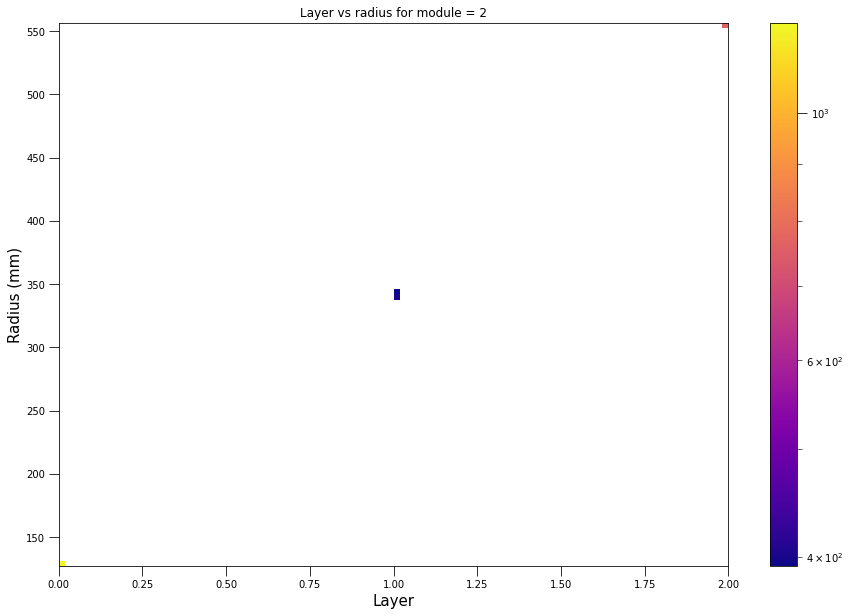

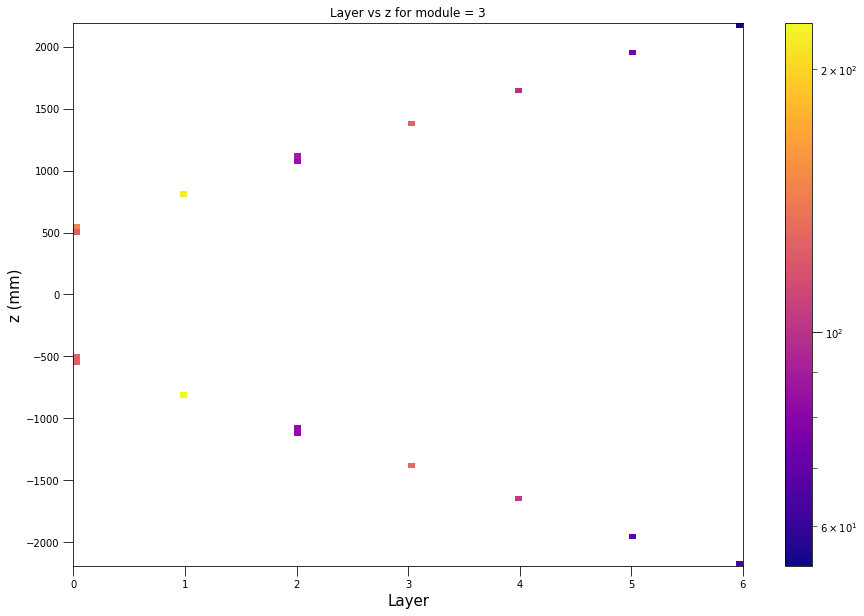

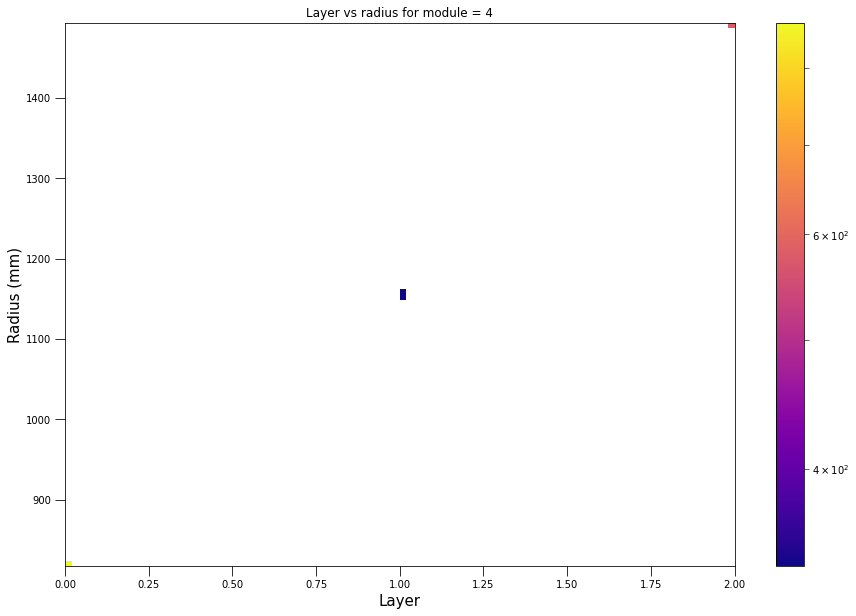

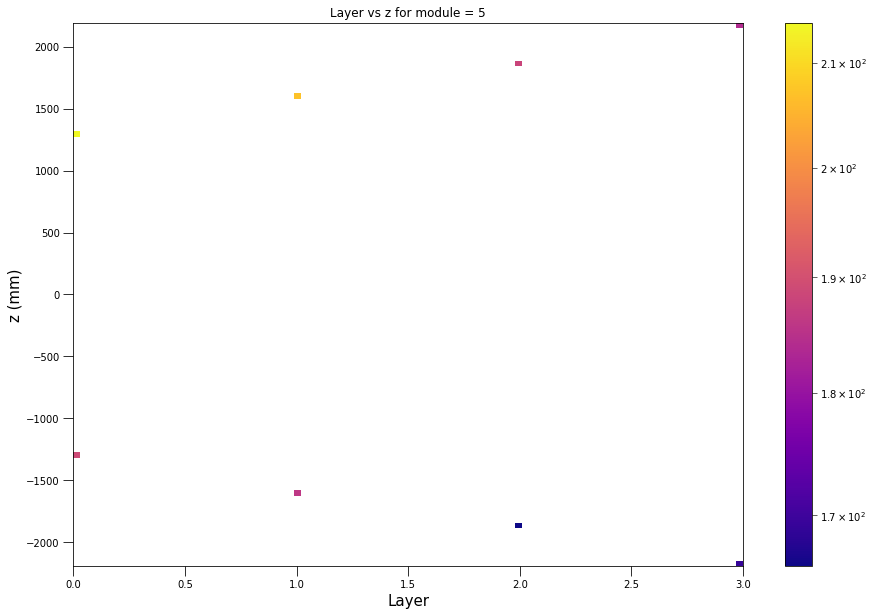

In [13]:
for i in range(6):
    inMod=(tree["module"].array()==(i+1))
    if i %2==0:
        plot2DHistogram(tree["layer"].array()[inMod], np.sqrt(tree["x"].array()[inMod]**2+tree["y"].array()[inMod]**2), bins=100, label=("Layer vs radius for module = "+str(i)+";Layer;Radius (mm)"))
    else:
        plot2DHistogram(tree["layer"].array()[inMod], tree["z"].array()[inMod], bins=100, label=("Layer vs z for module = "+str(i)+";Layer;z (mm)"))

#### The above two graphs show that for each module value, the layer value coorespondes to the individual layers of the detector. Specifically layer=0 being the inner most layer, layer=1 being the second inner most layer, etc.

# Finding the variance of the time distributions per layer

In [14]:
layerPerModule={
    1 : 8,
    2 : 8,
    3 : 3,
    4 : 7,
    5 : 3,
    6 : 4
} #dictionairy to help loop over all layers later

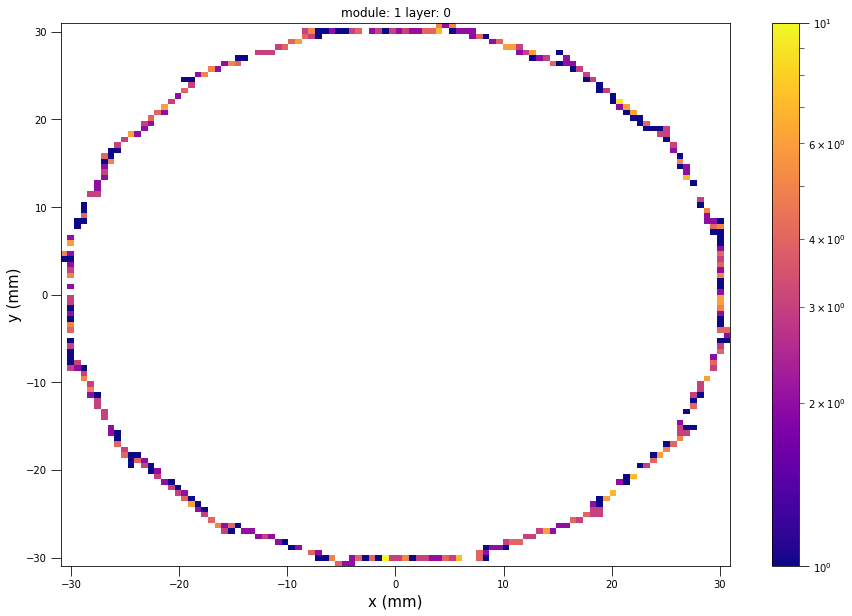

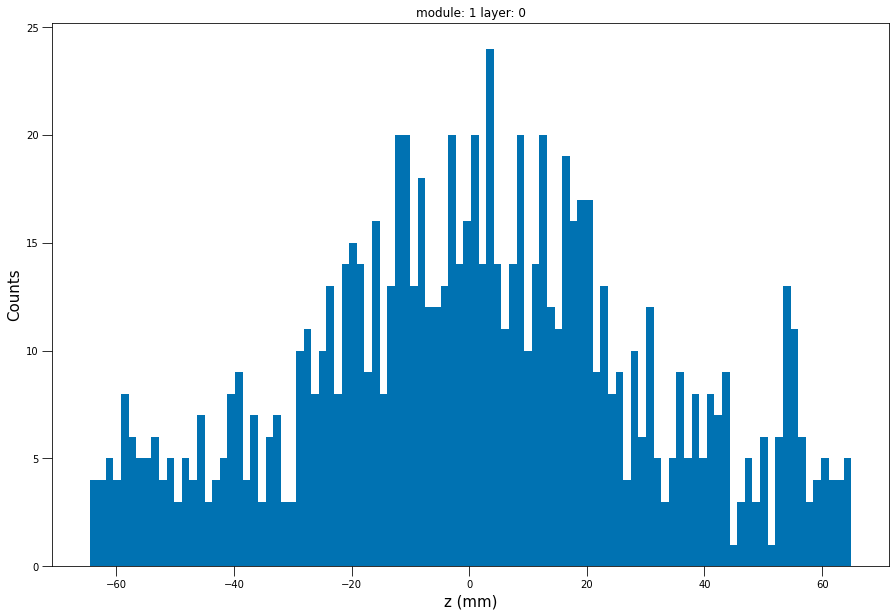

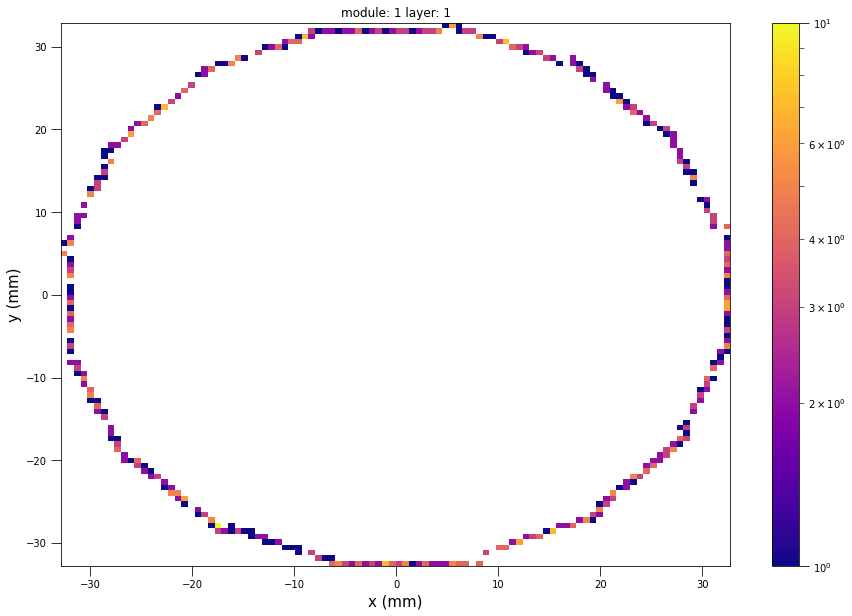

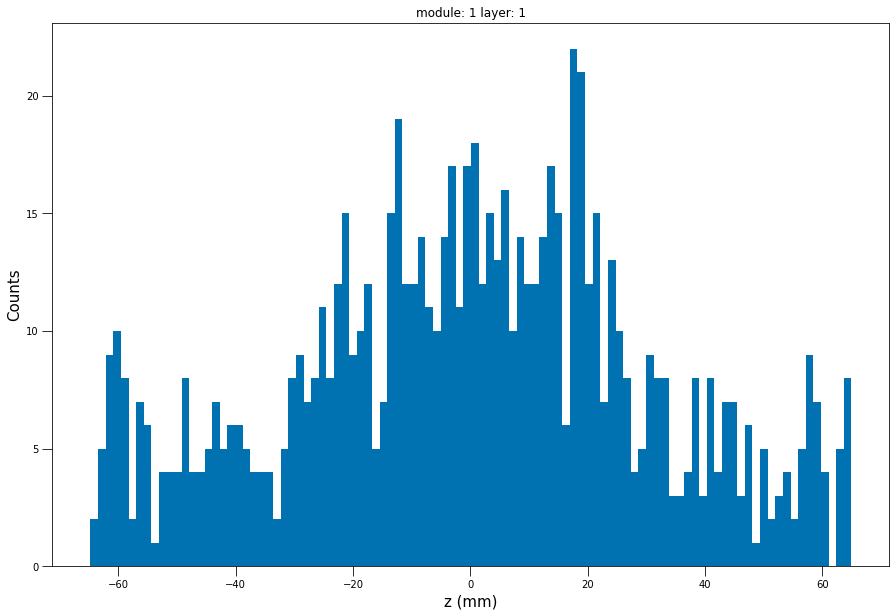

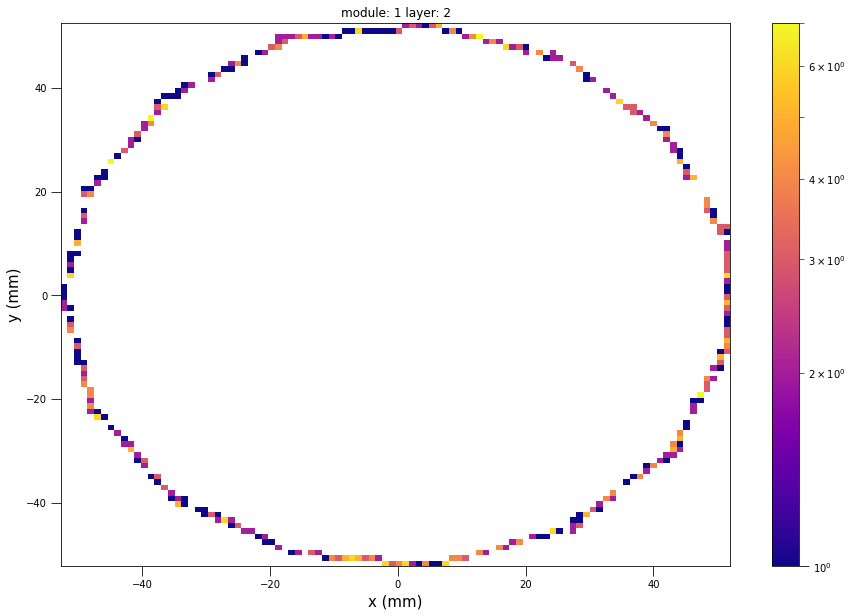

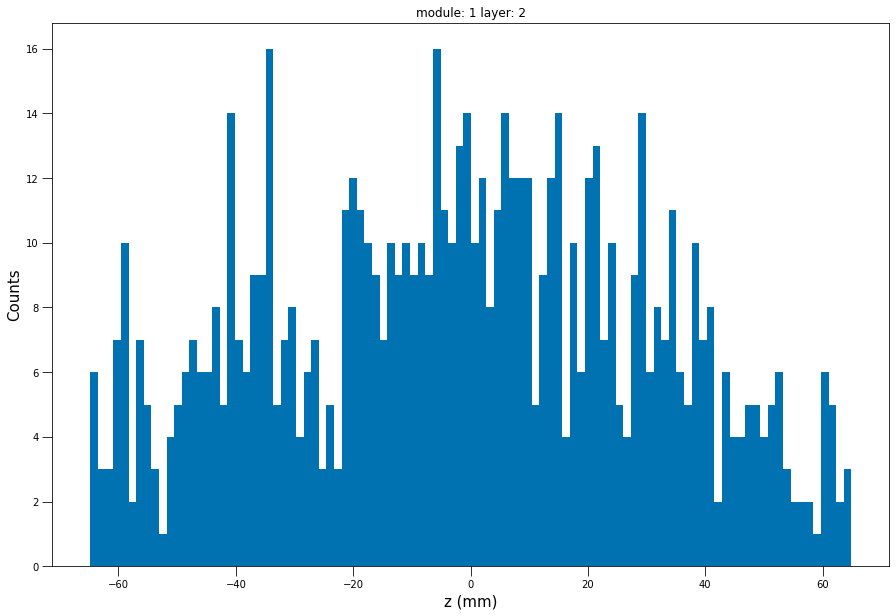

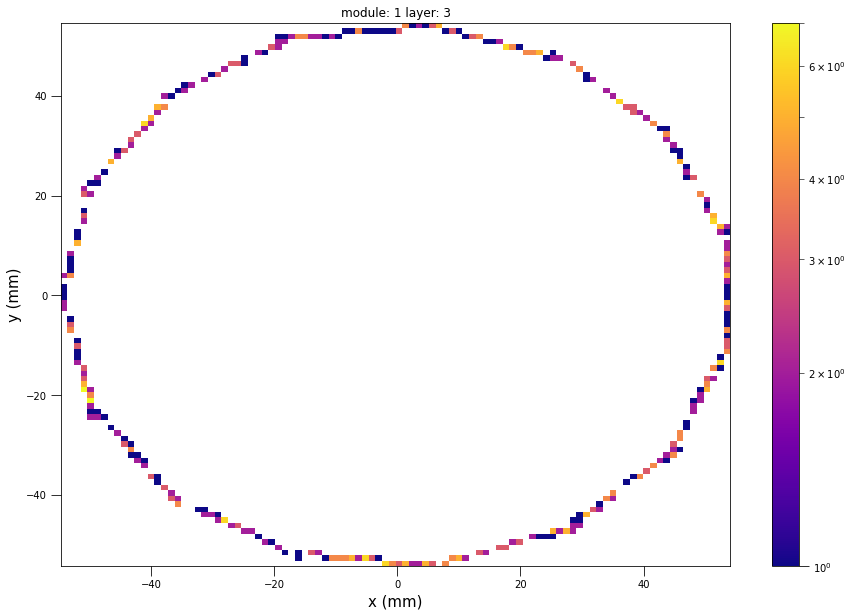

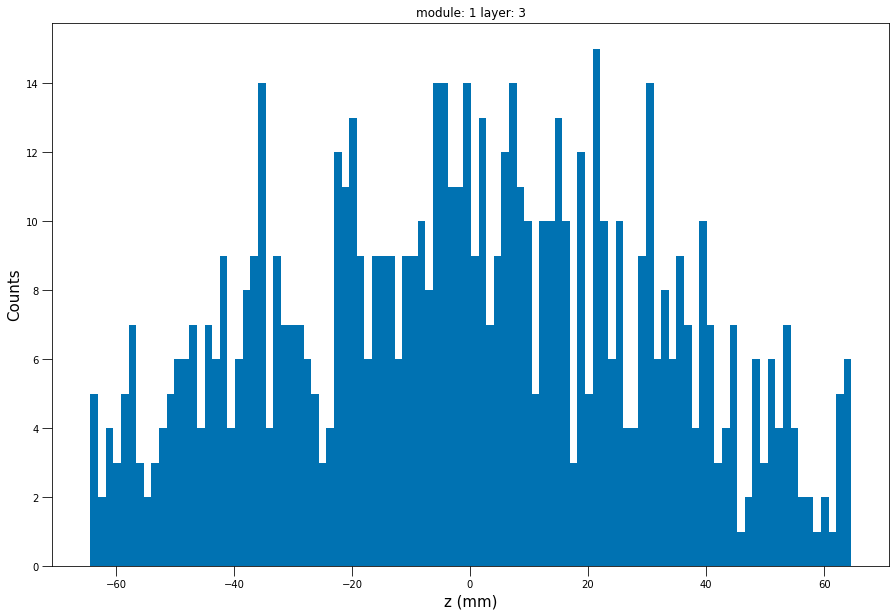

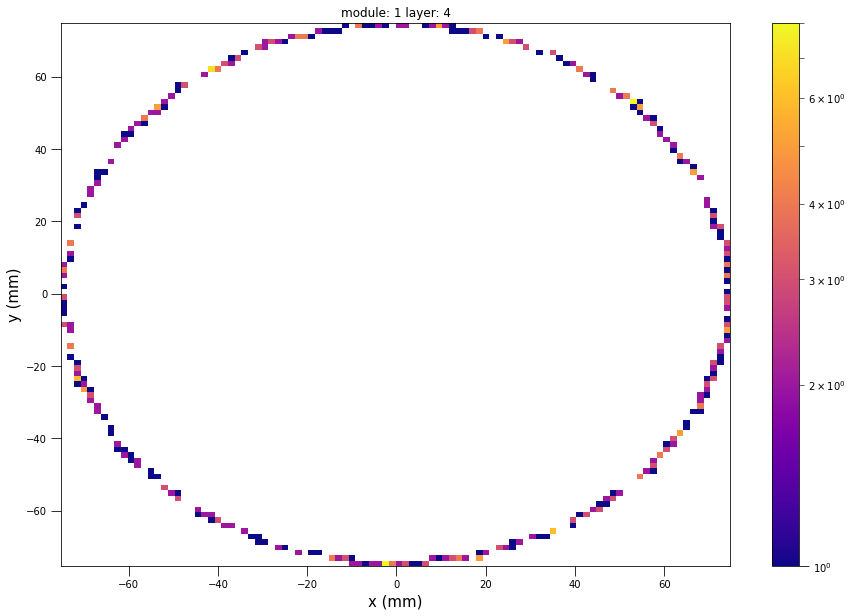

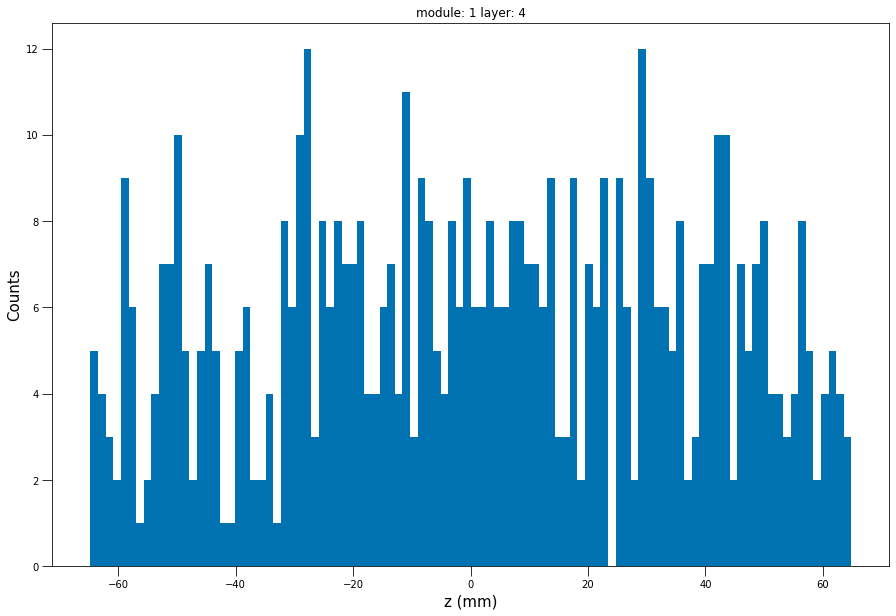

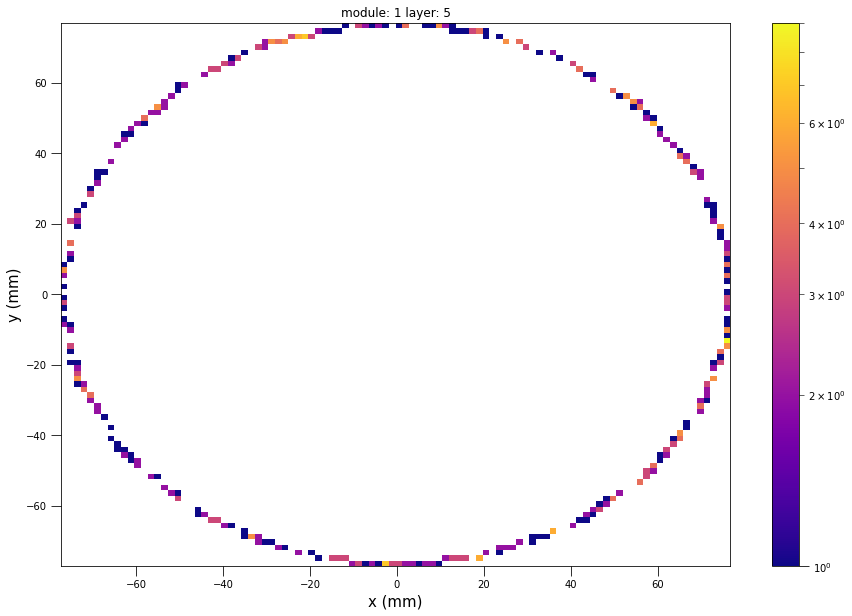

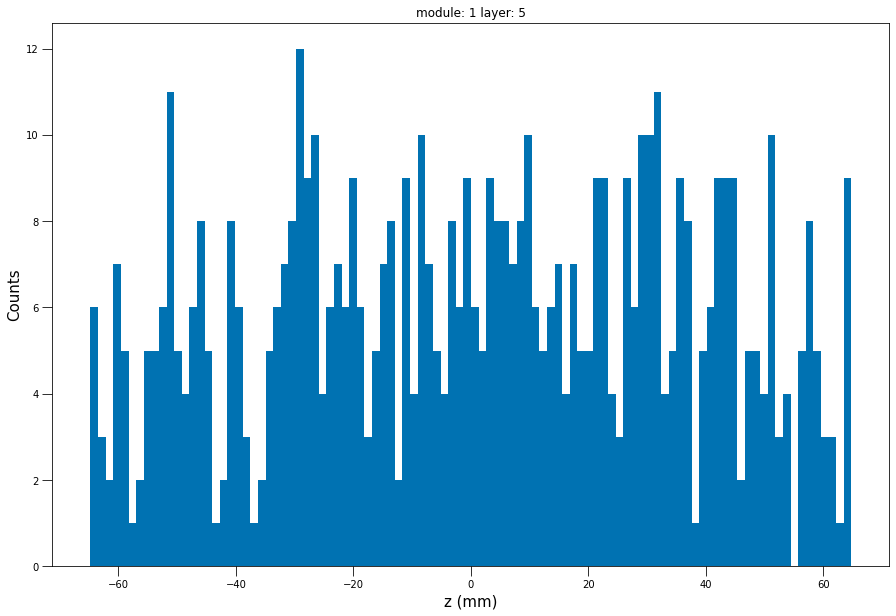

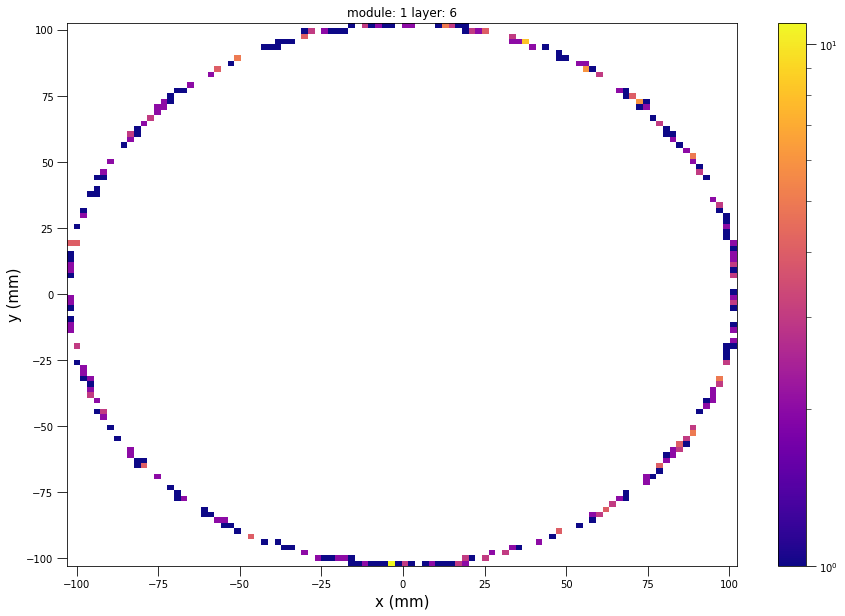

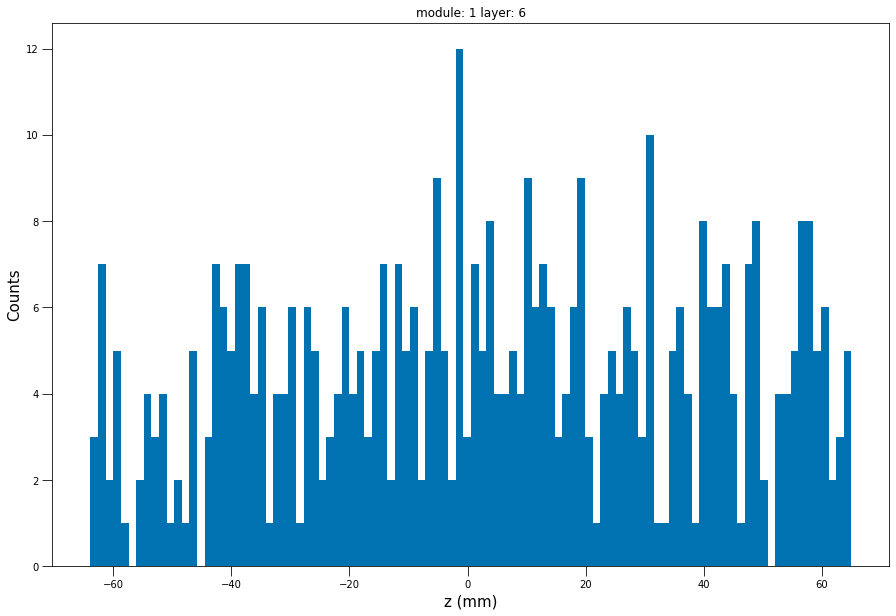

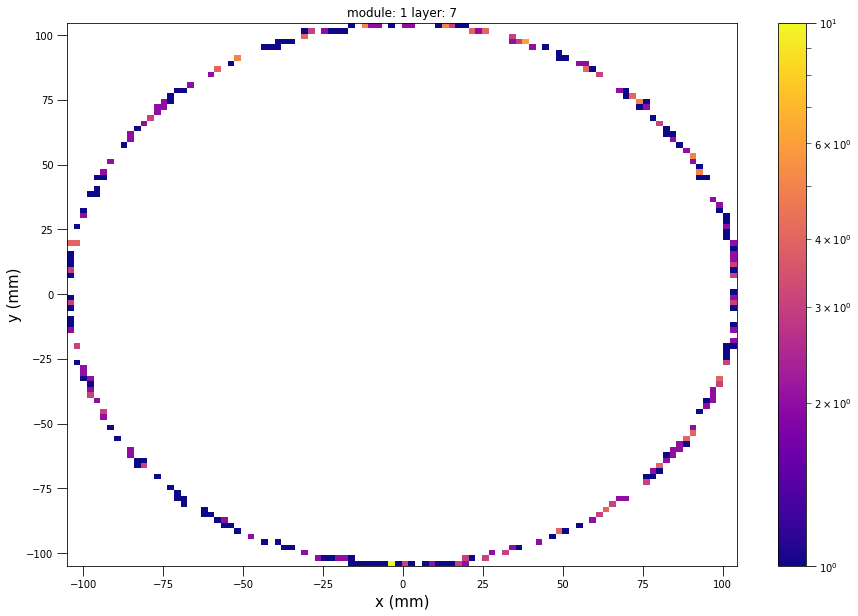

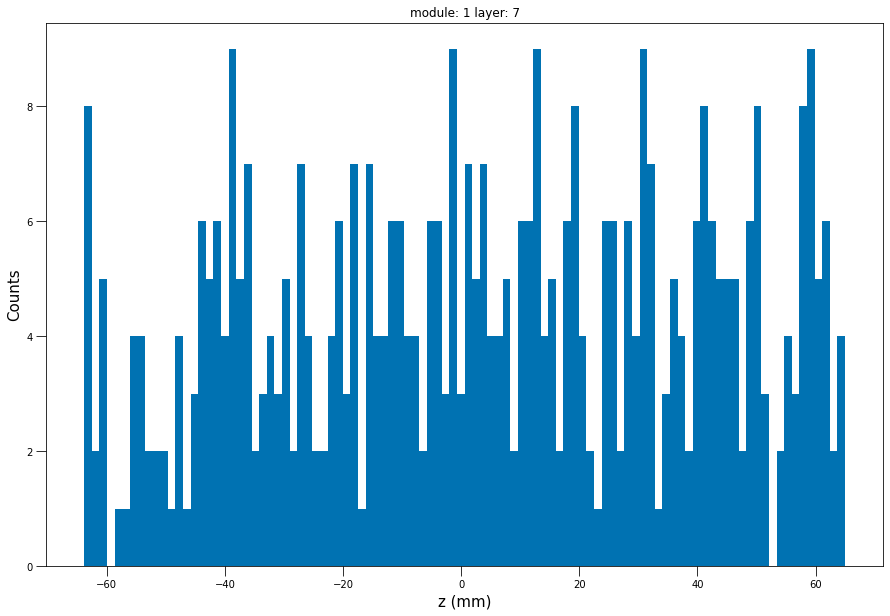

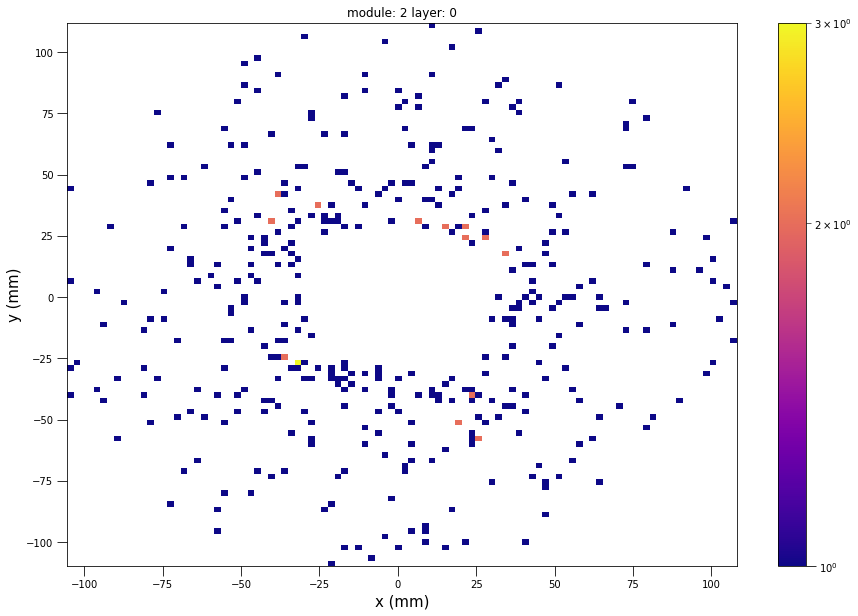

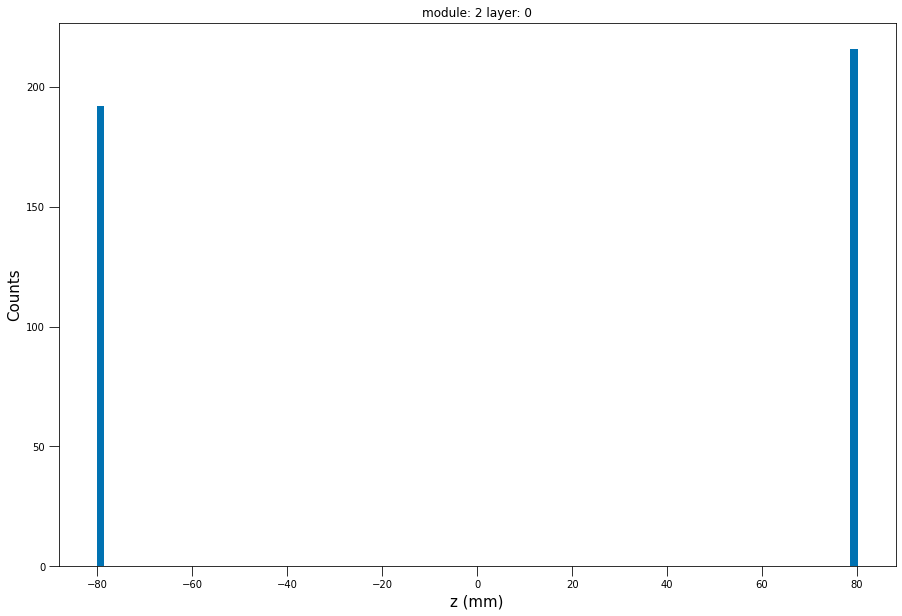

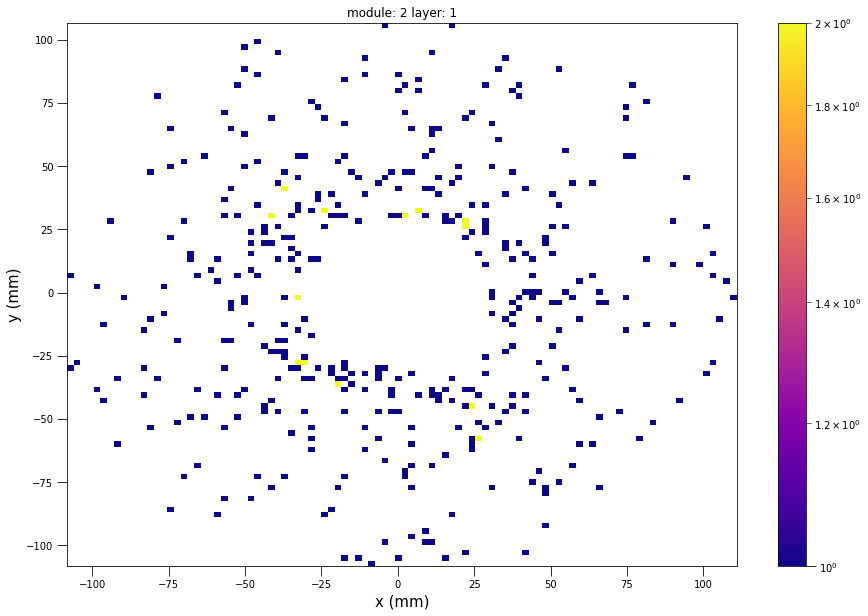

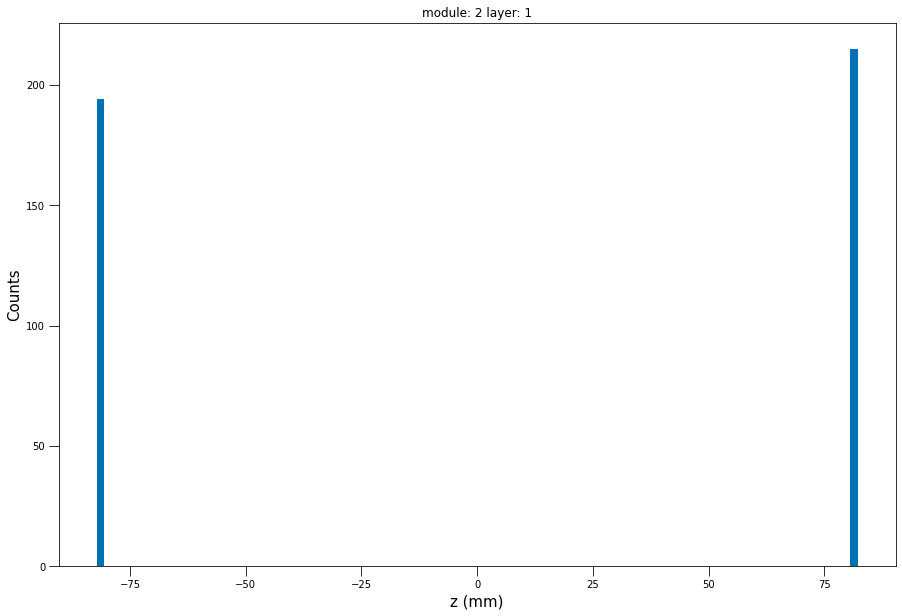

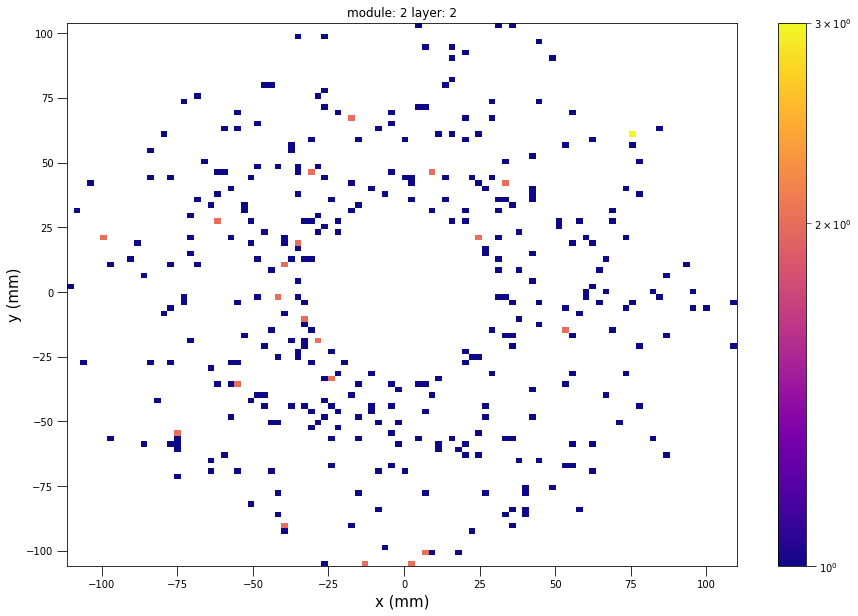

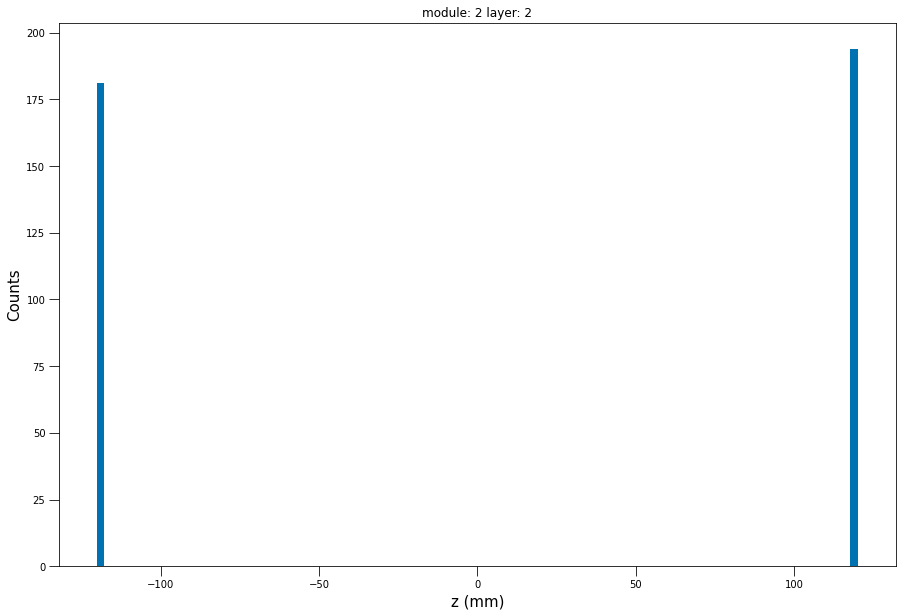

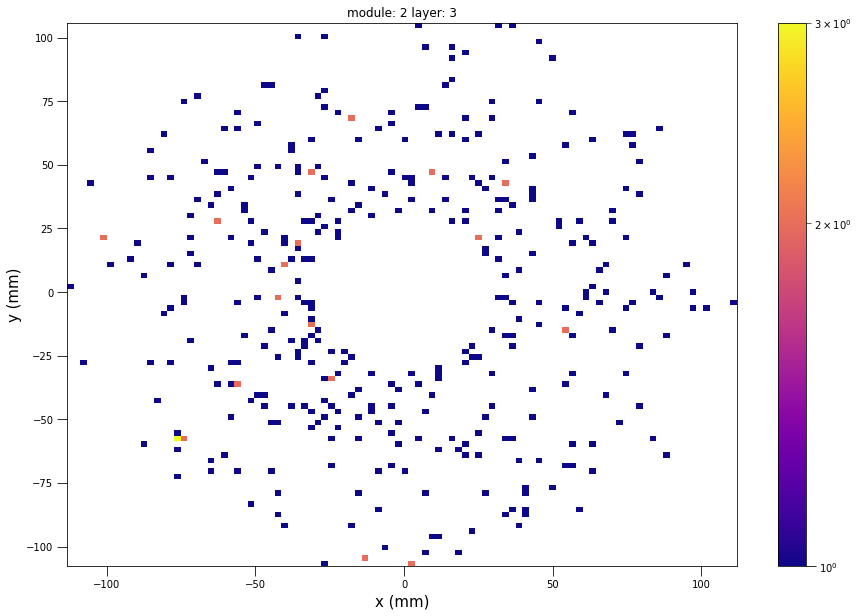

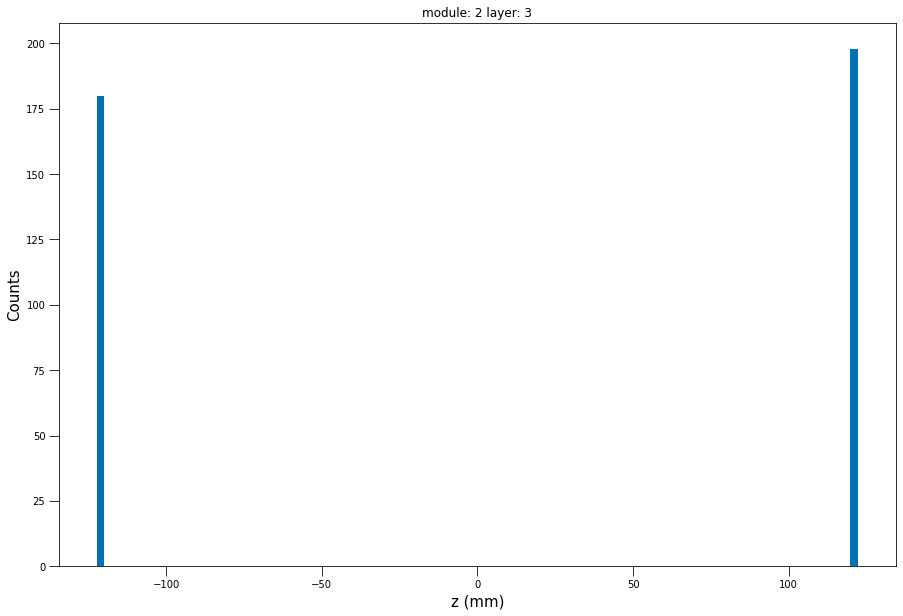

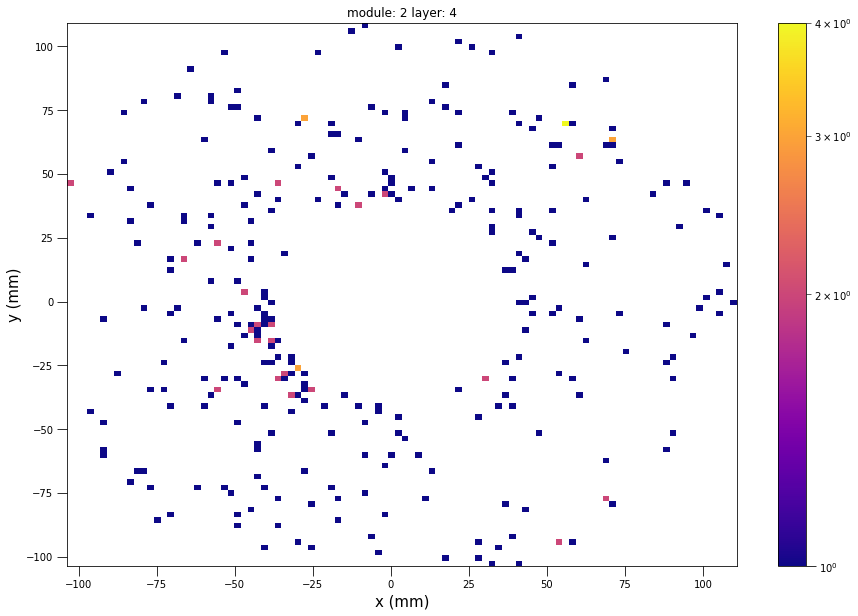

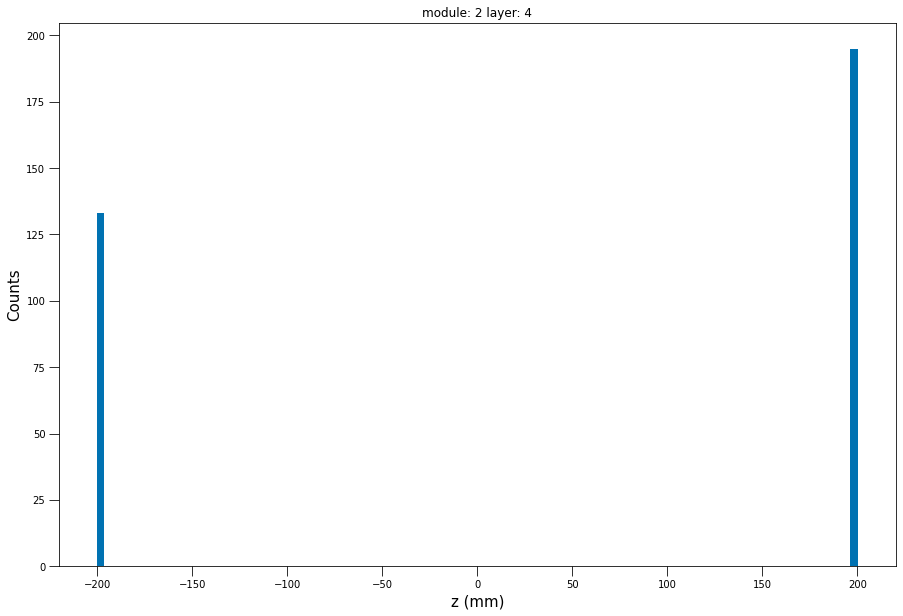

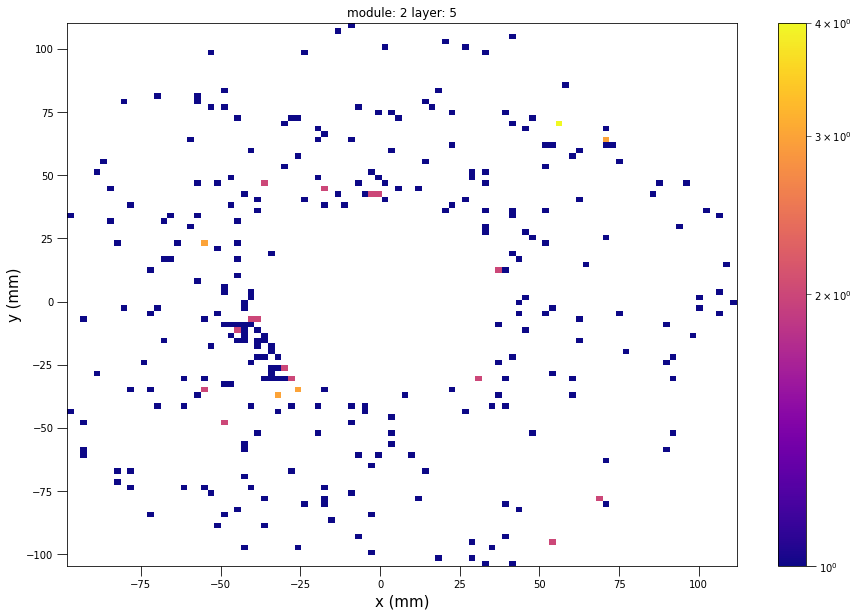

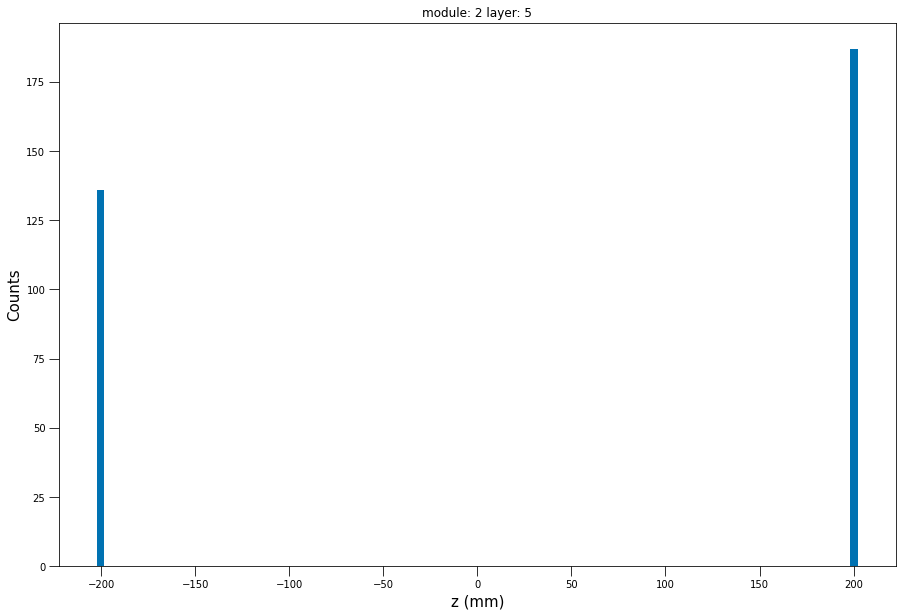

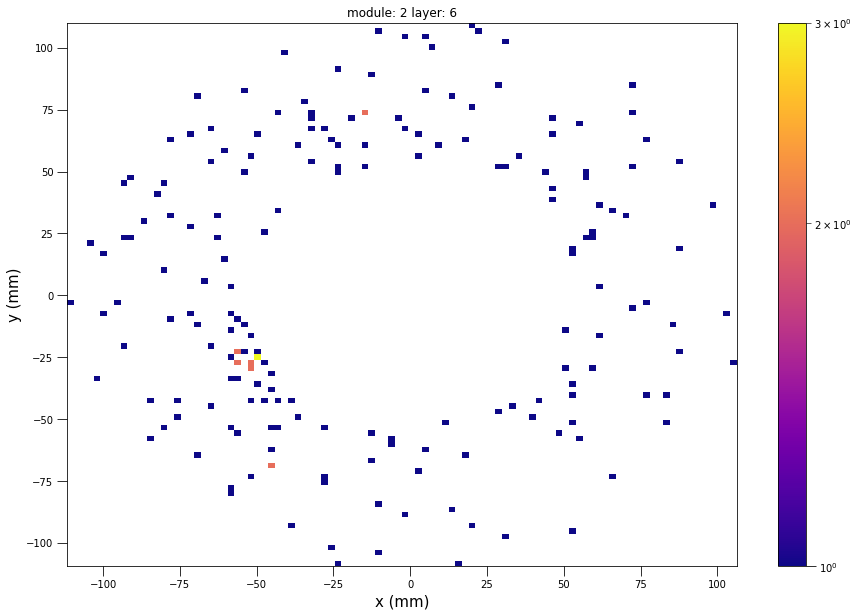

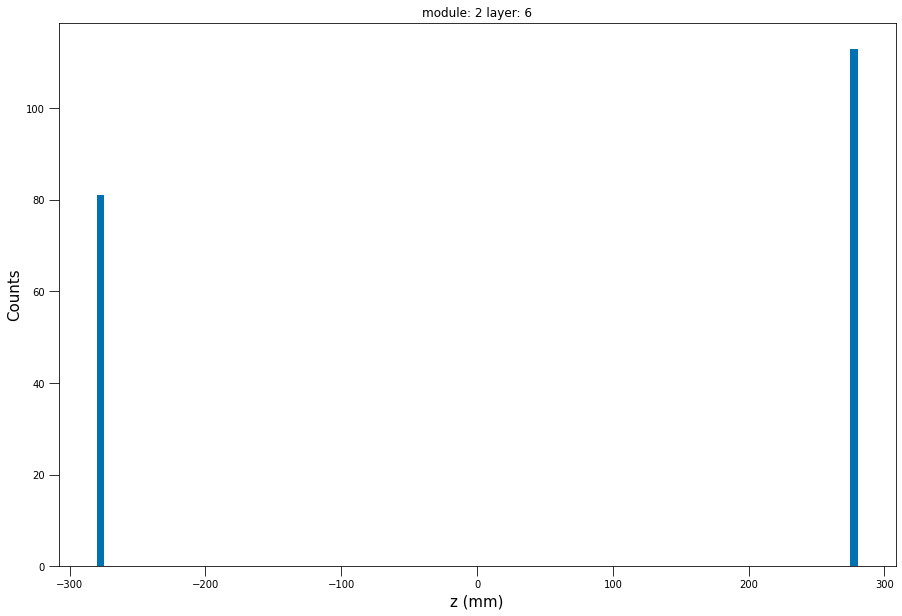

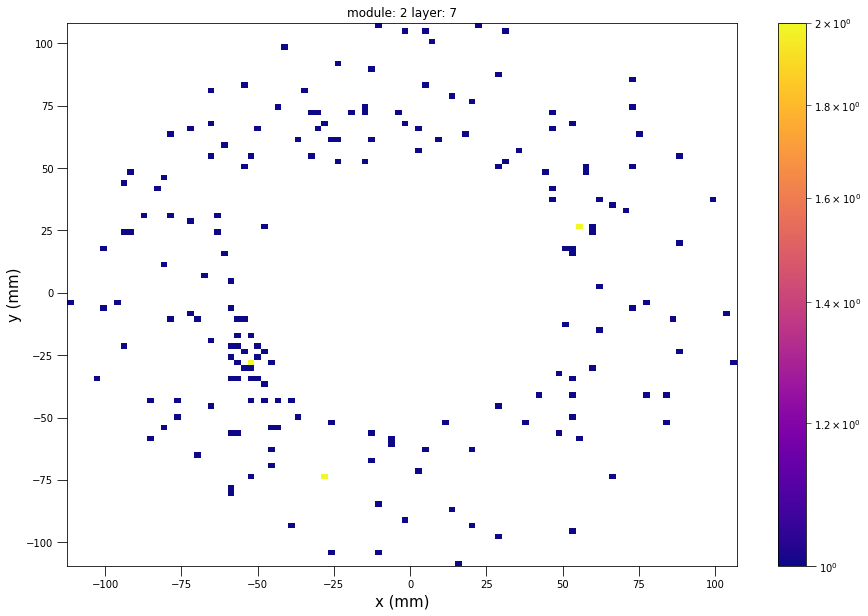

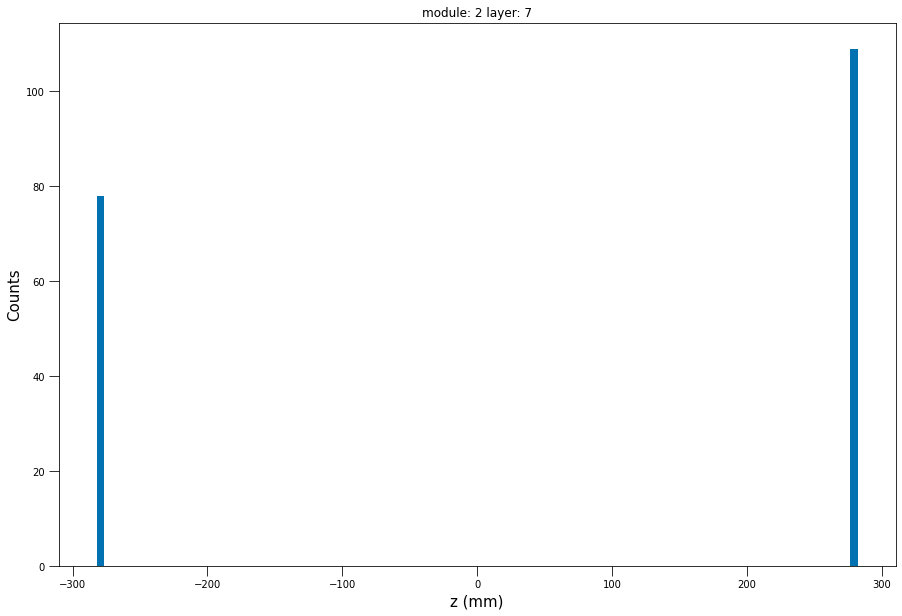

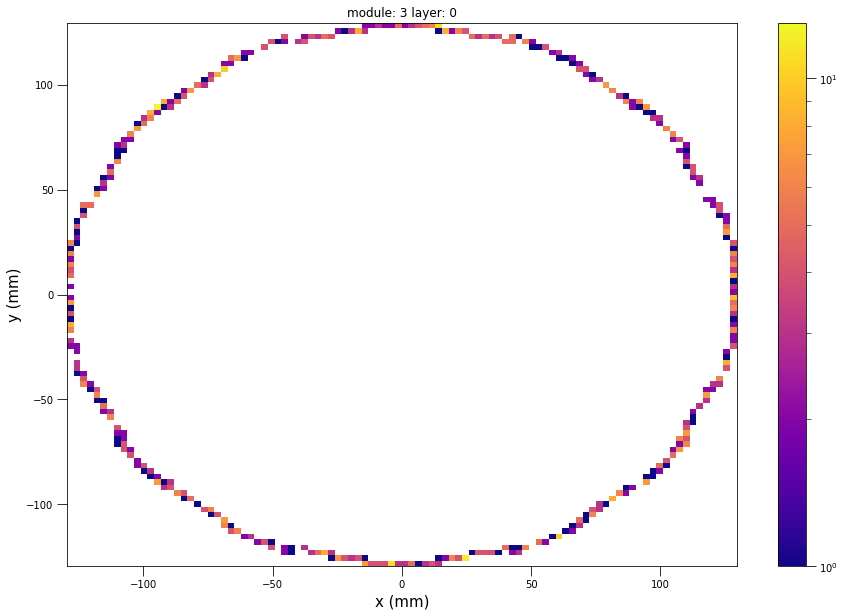

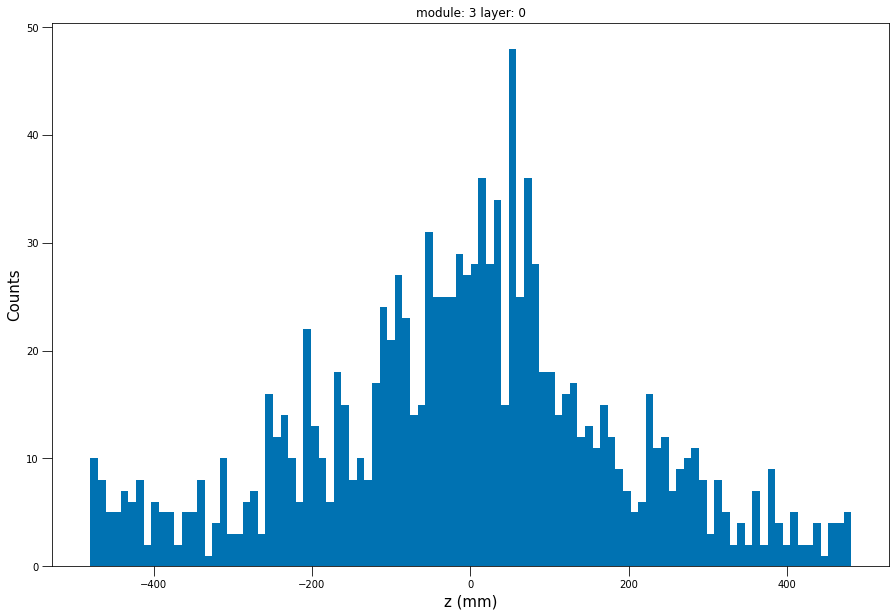

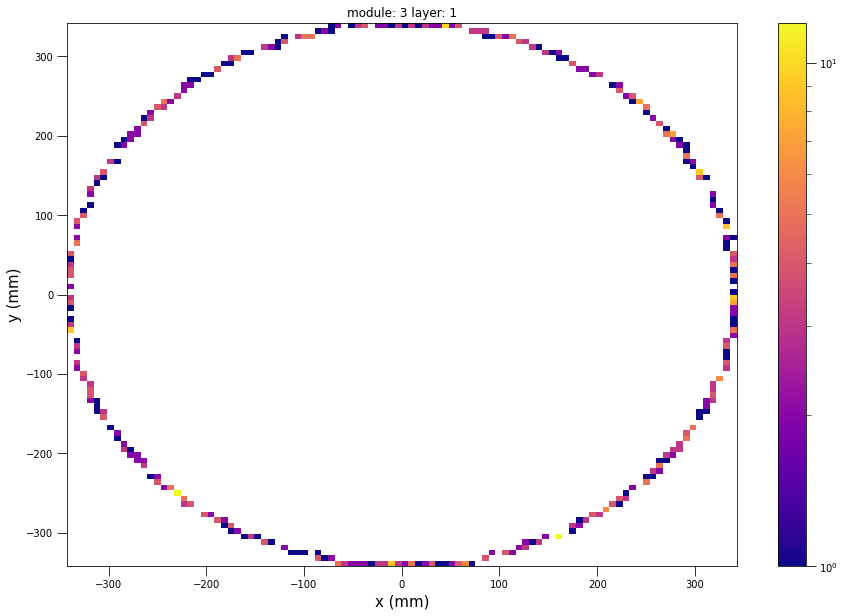

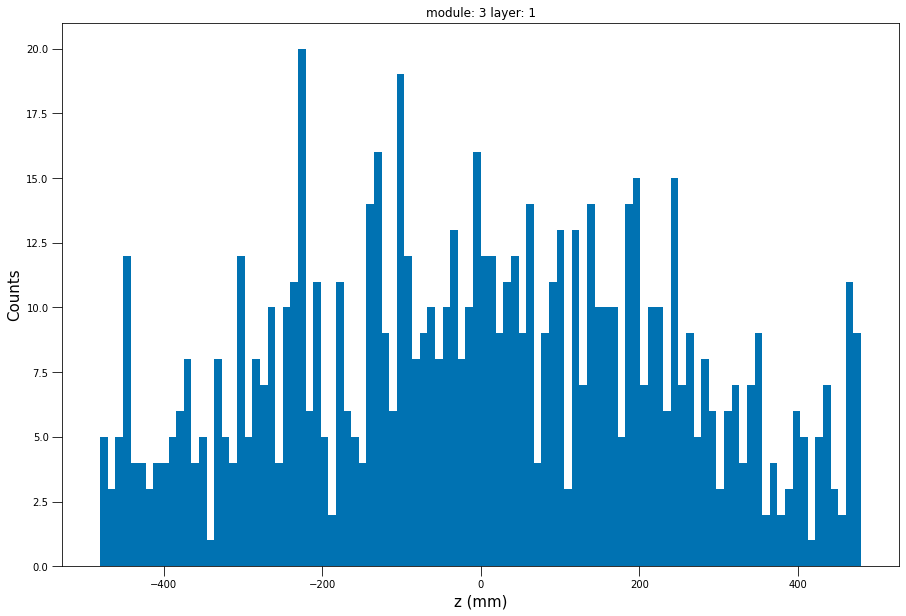

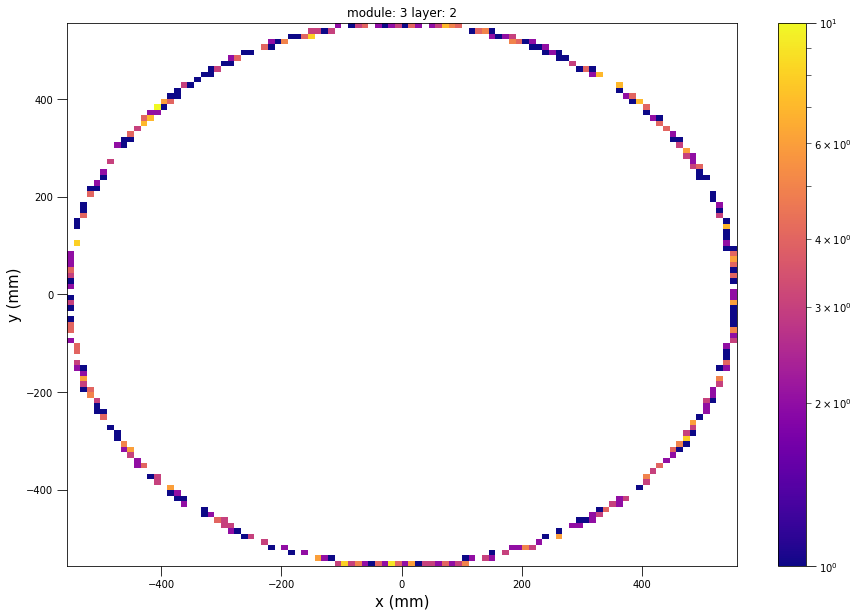

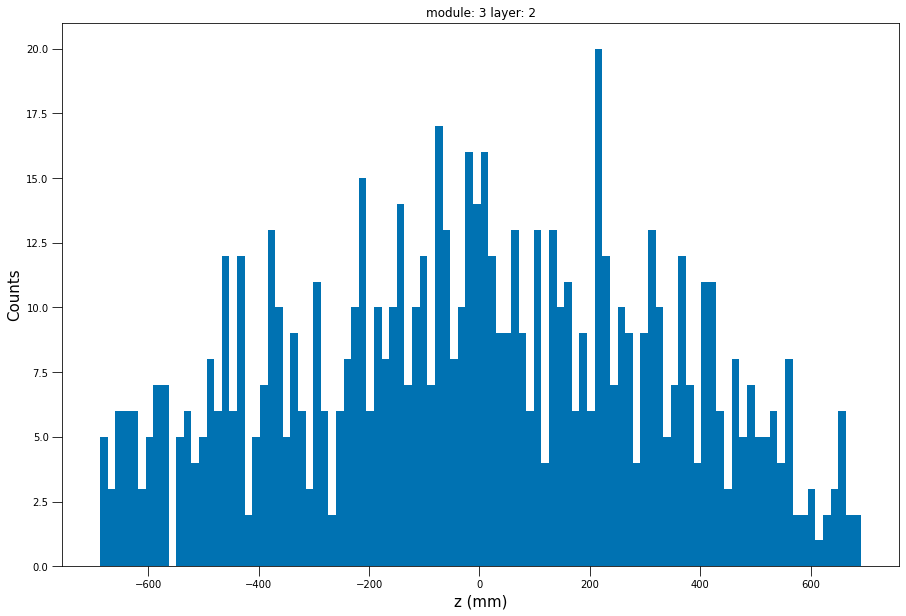

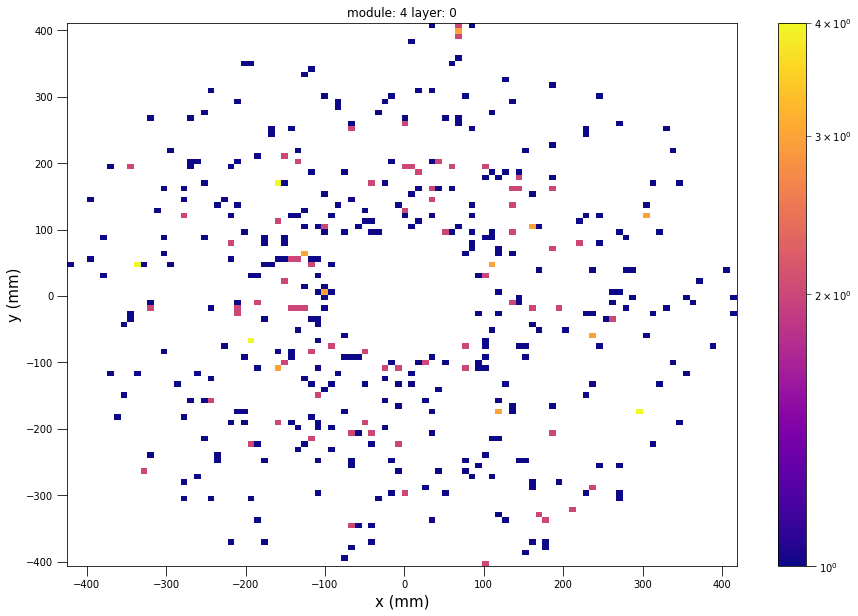

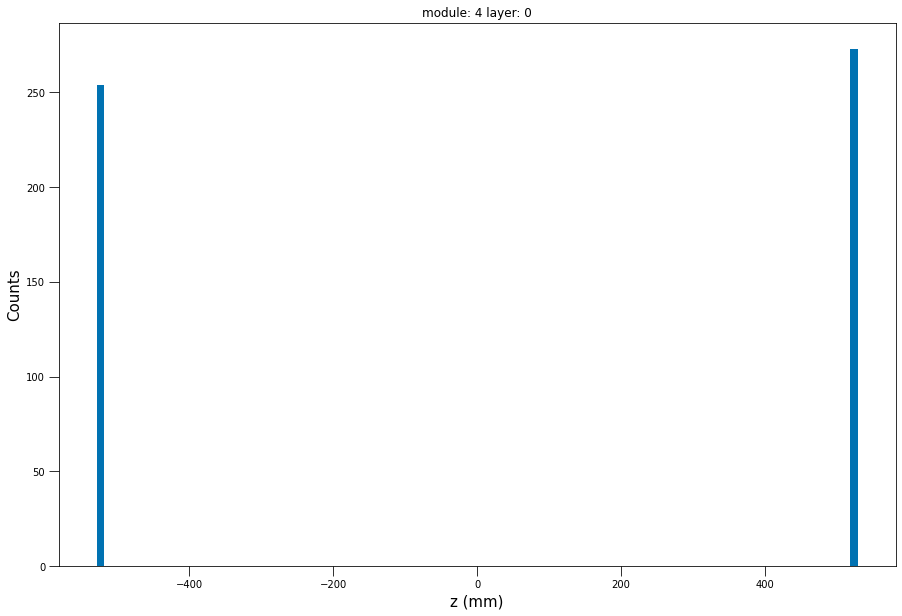

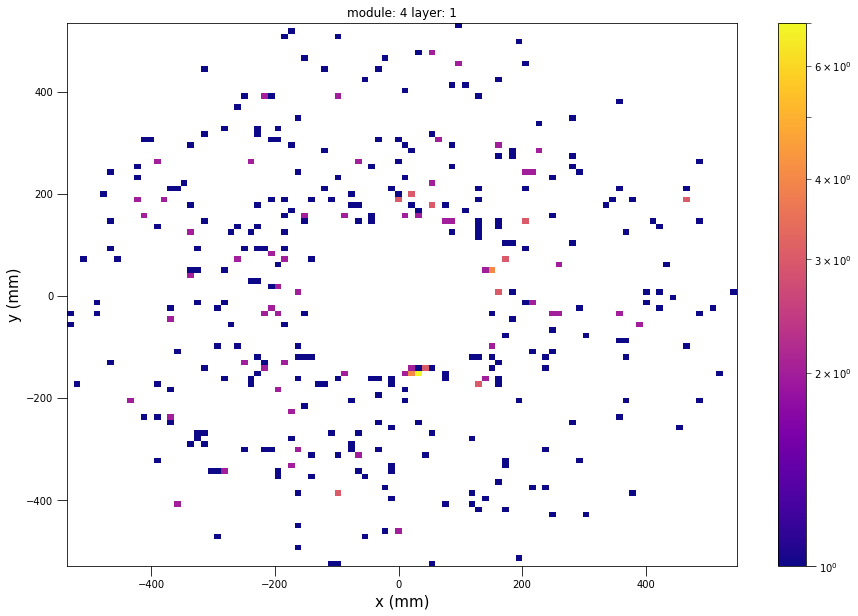

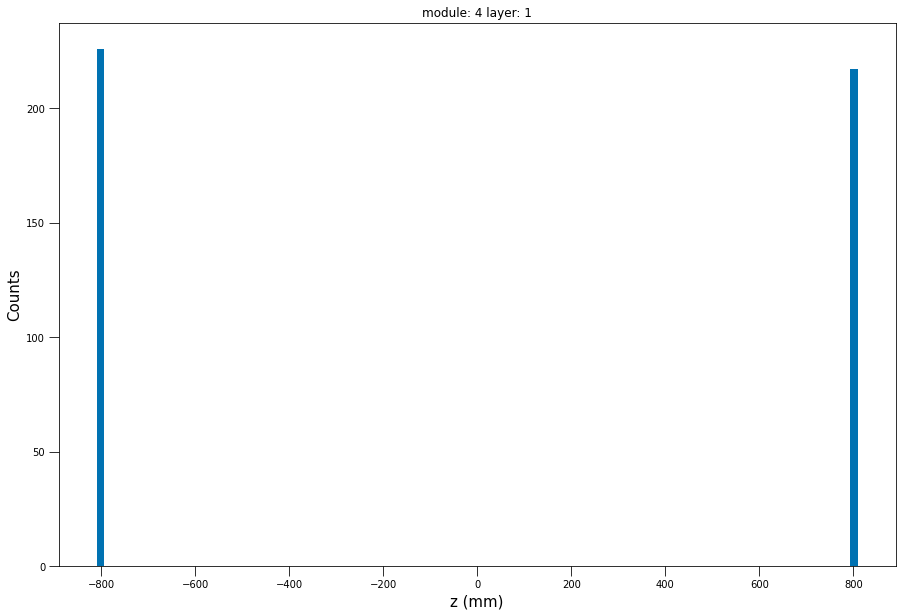

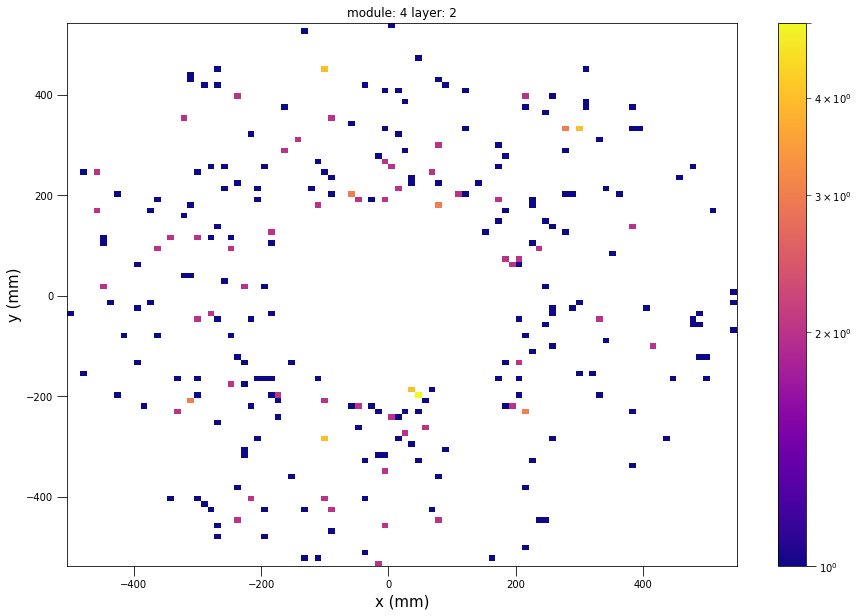

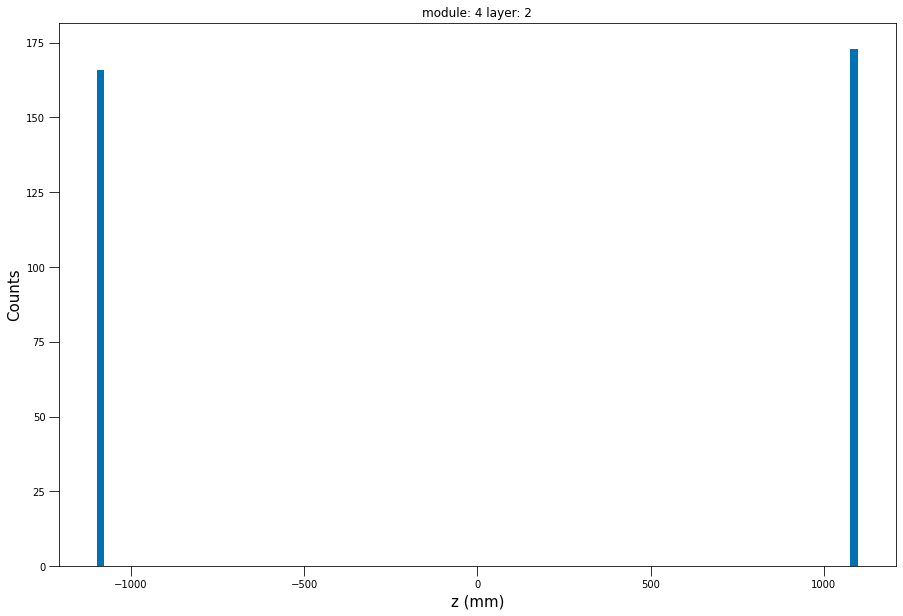

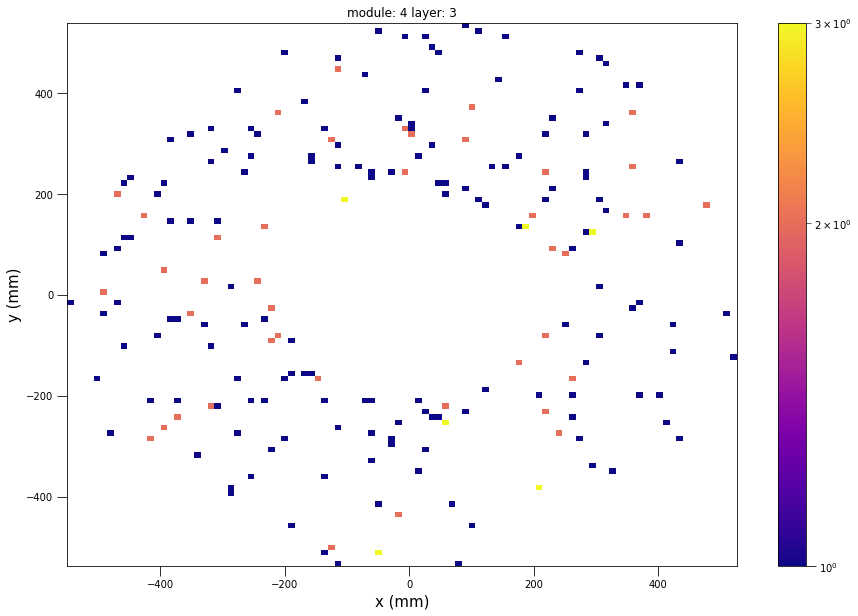

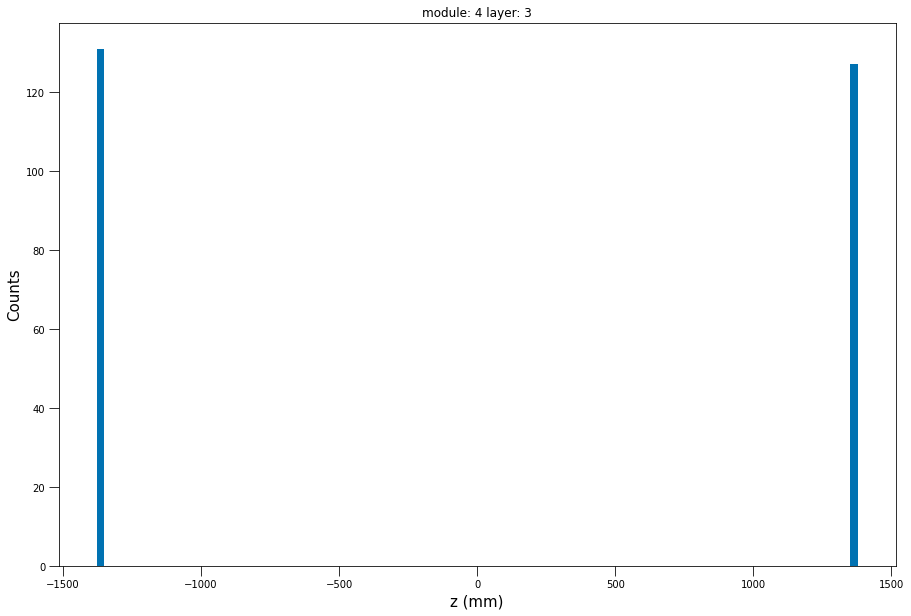

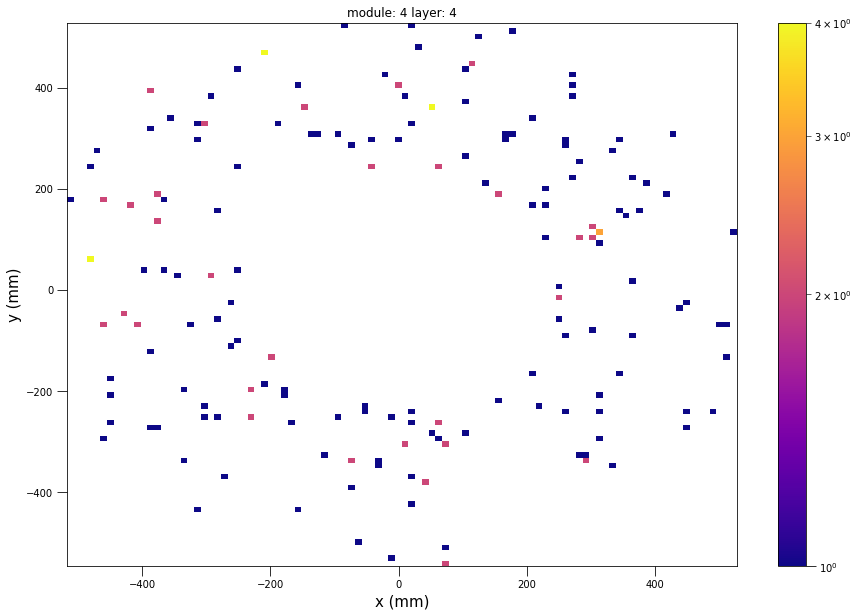

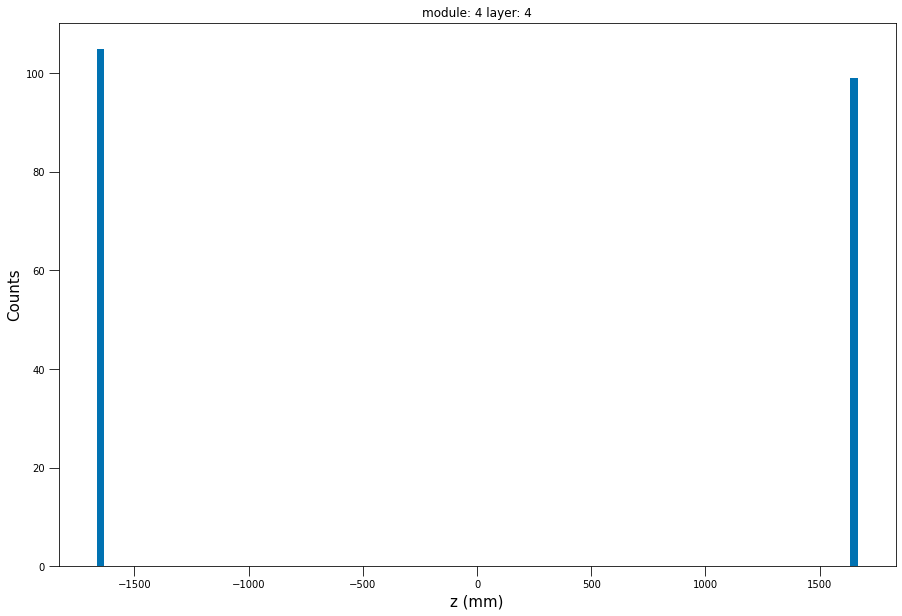

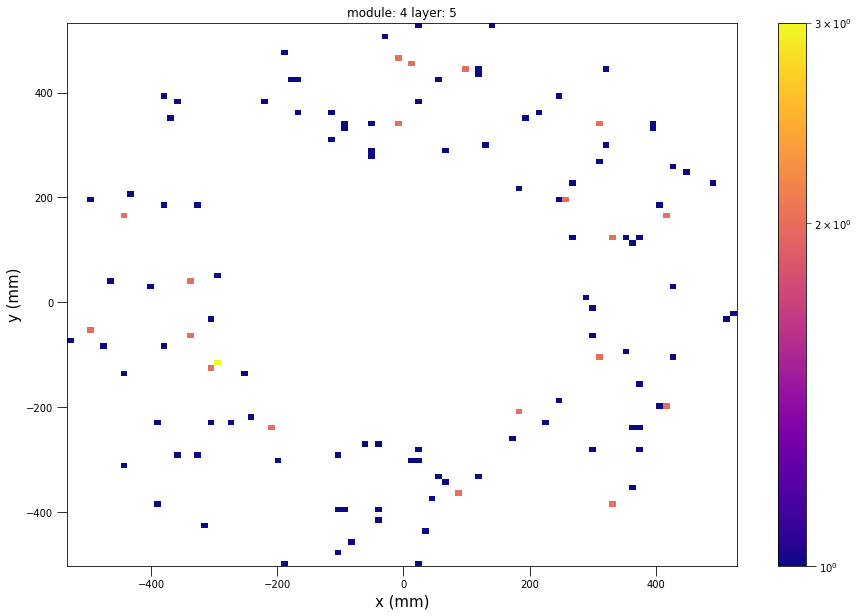

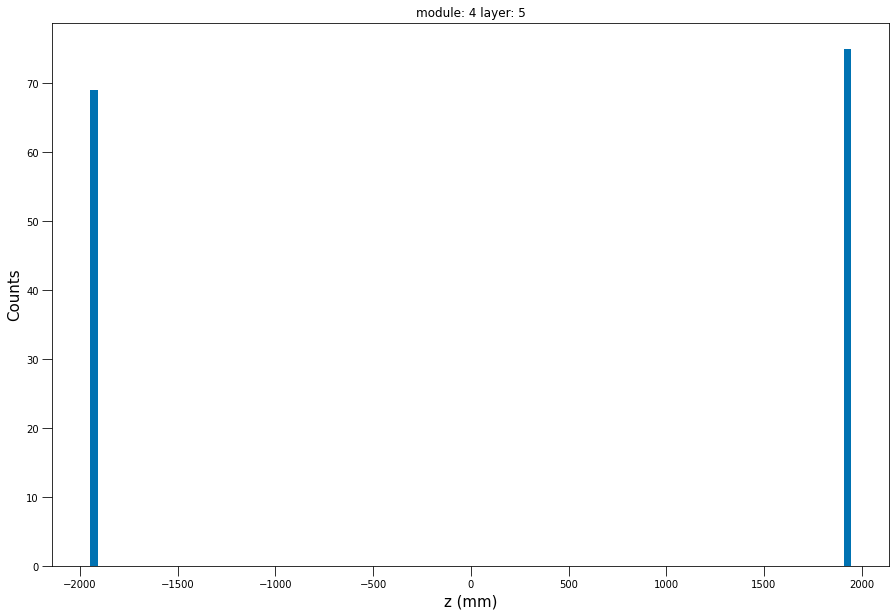

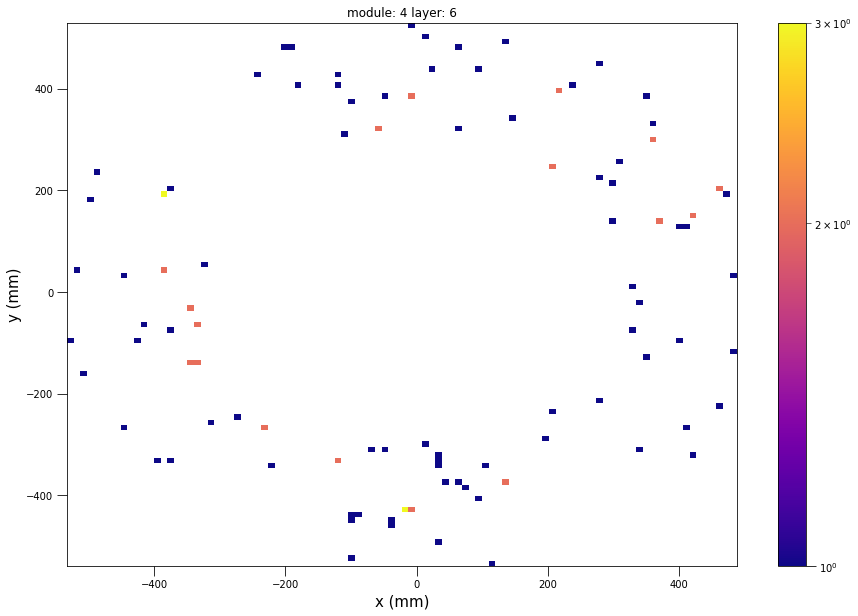

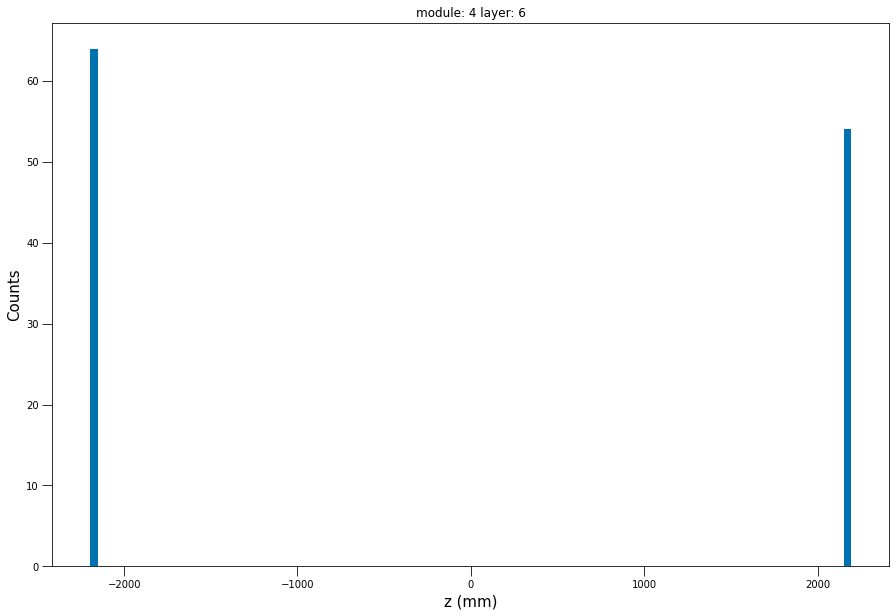

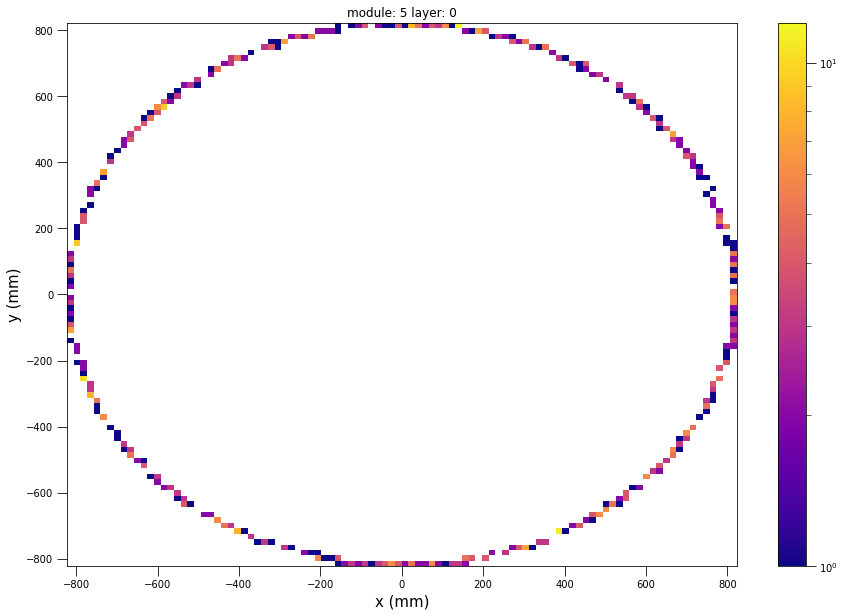

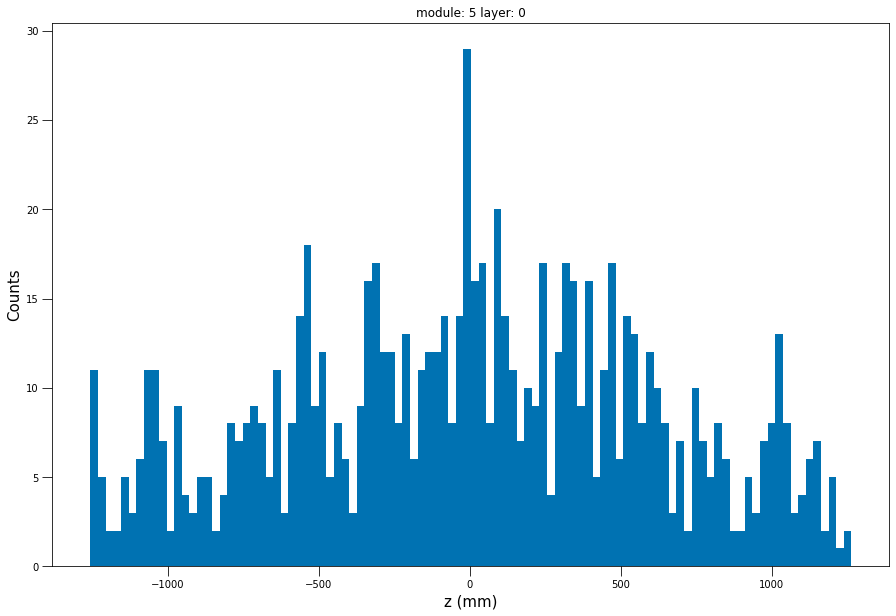

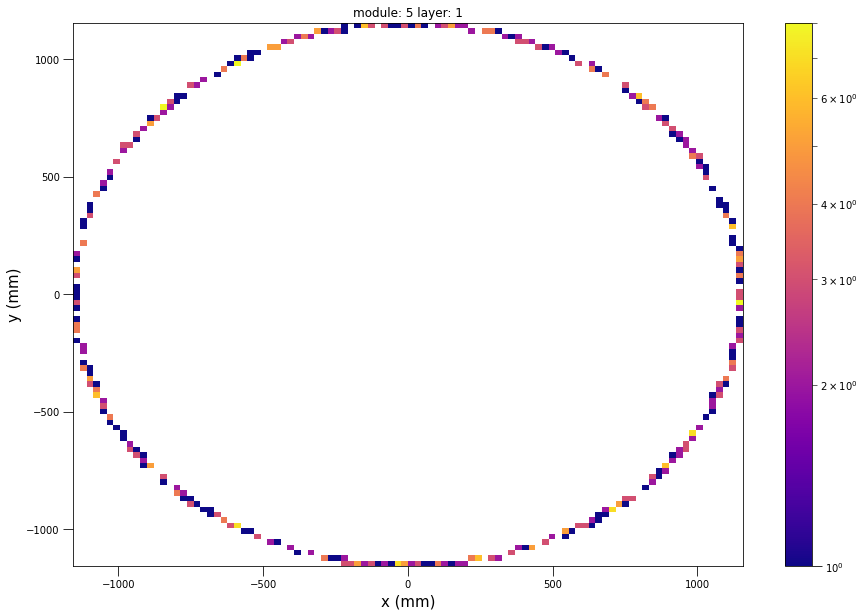

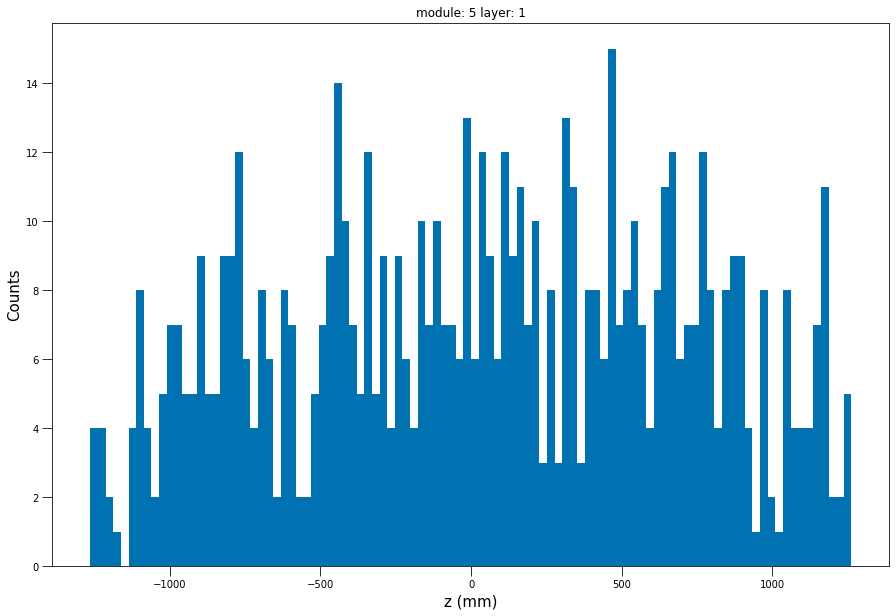

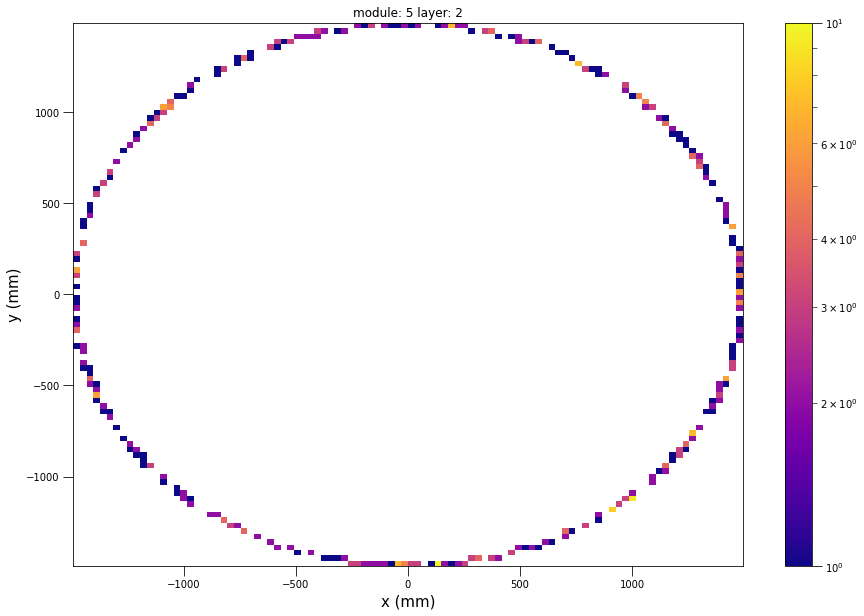

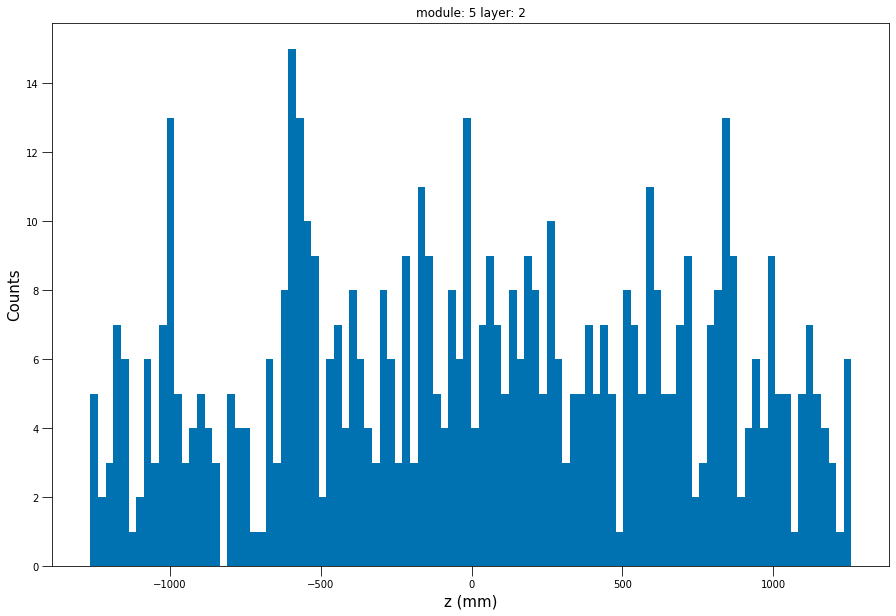

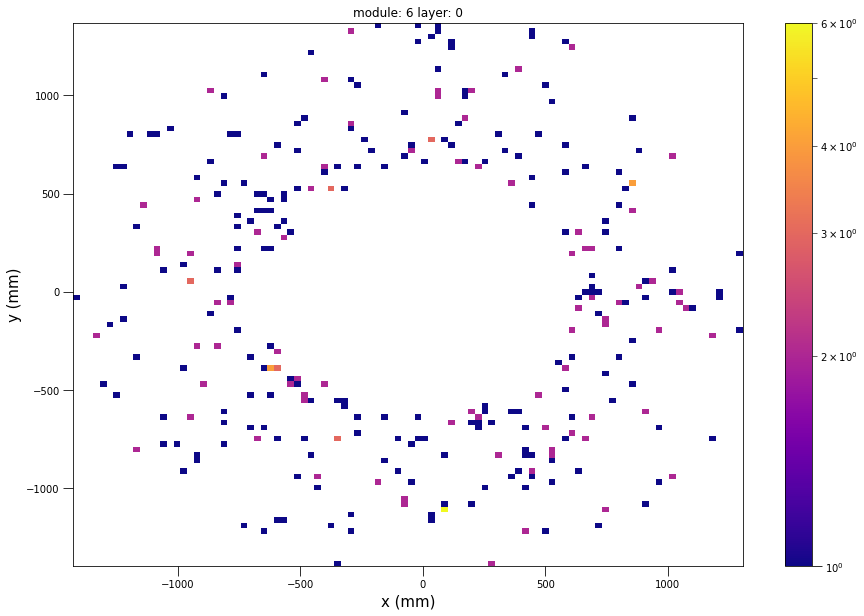

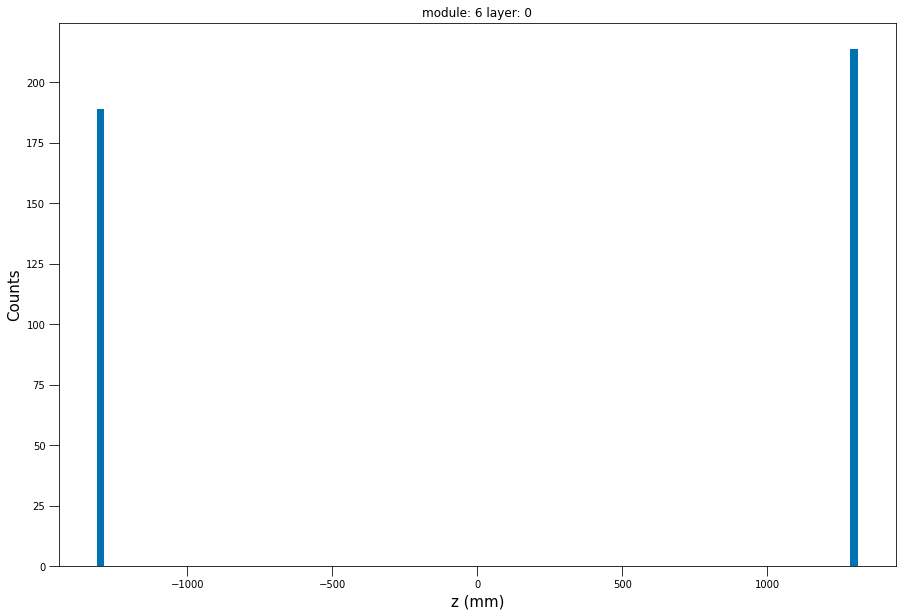

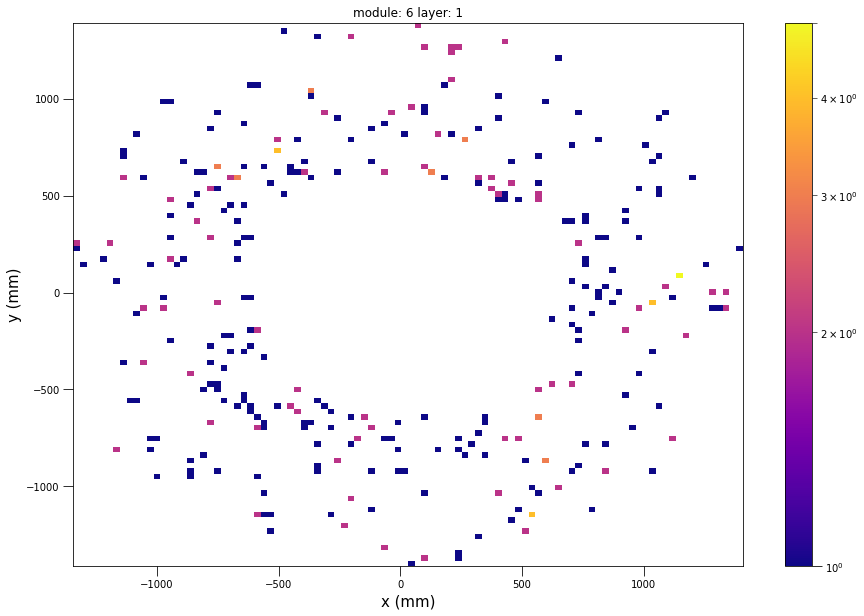

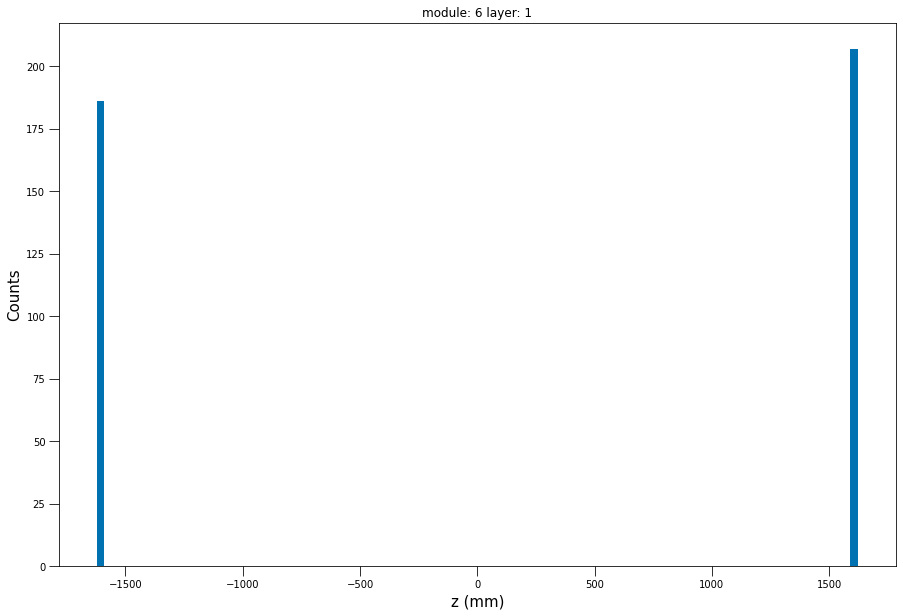

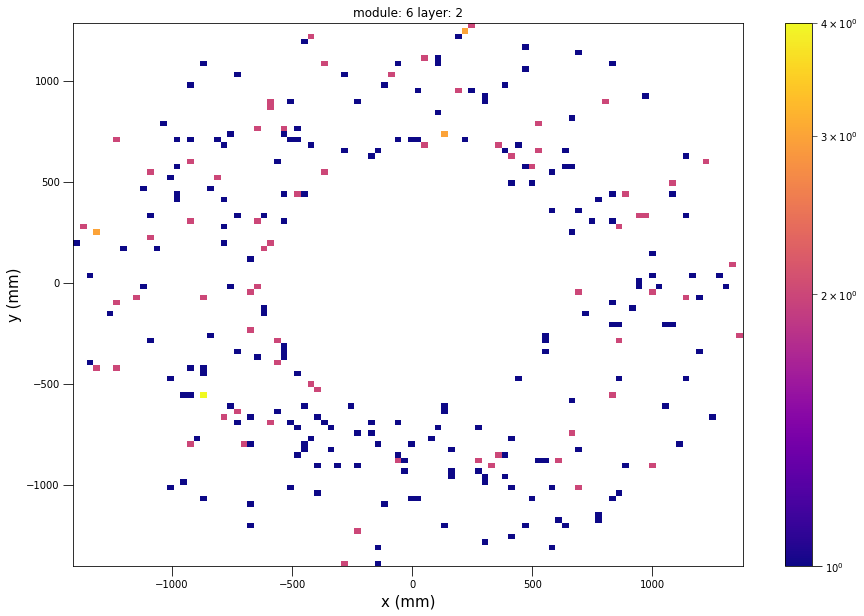

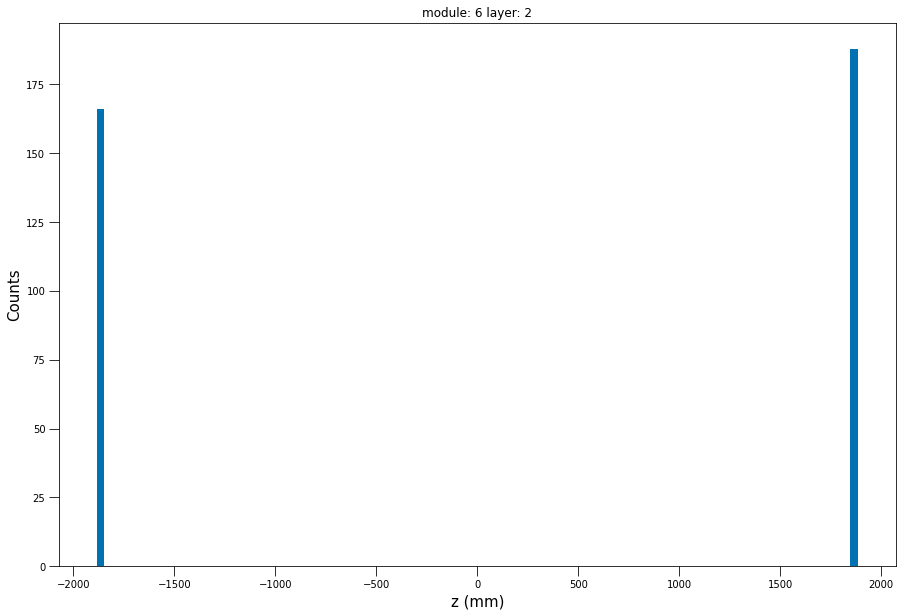

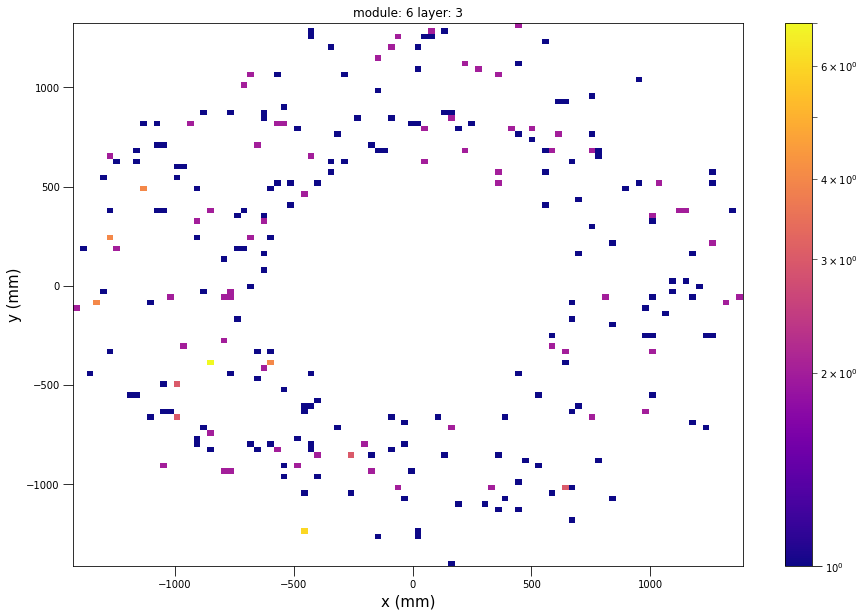

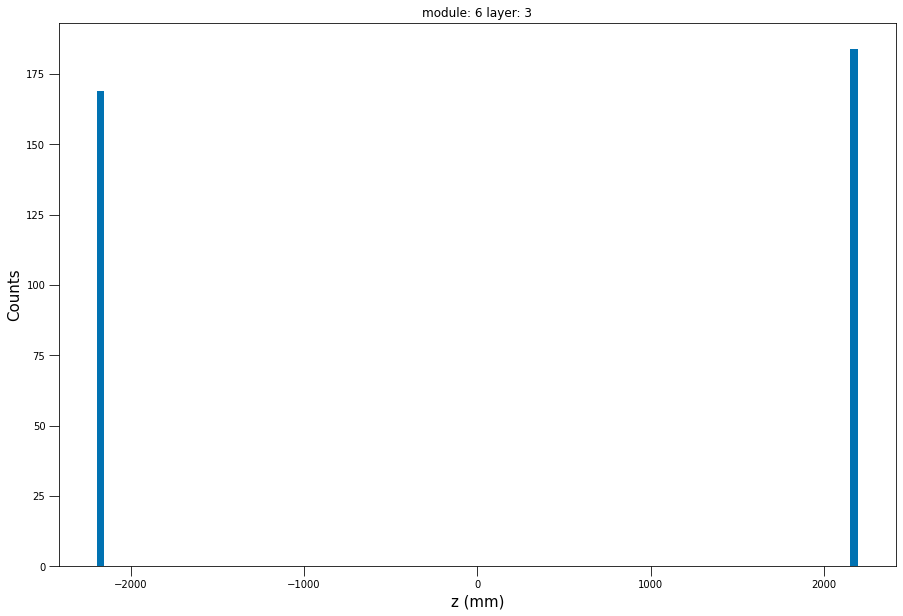

In [15]:
#Complete list of every module and layer.
#This is mostly to fix any confusion/for those who haven't looked at the geometry of the detector
for i in range(6):
    inMod=(tree["module"].array()==i+1)
    for j in range(layerPerModule[i+1]):
        inLayer=(tree["layer"].array()==j)
        inside=inLayer & inMod
        plot2DHistogram(tree["x"].array()[inside], tree["y"].array()[inside], label=("module: " +str(i+1) + " layer: " + str(j) +";x (mm);y (mm)"))
        plot1DHistogram(tree["z"].array()[inside], bins=100, label=("module: " +str(i+1) + " layer: " + str(j) +";z (mm);Counts"))

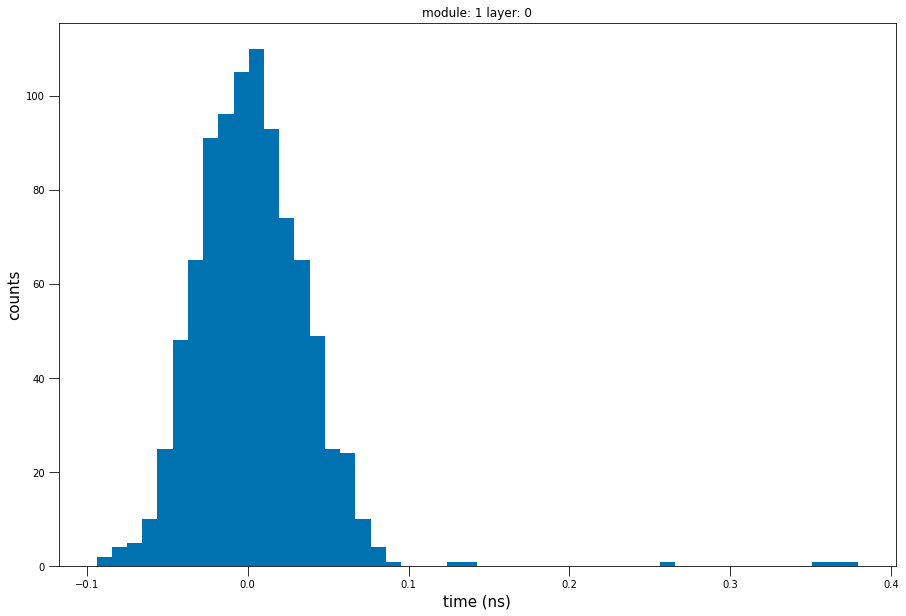

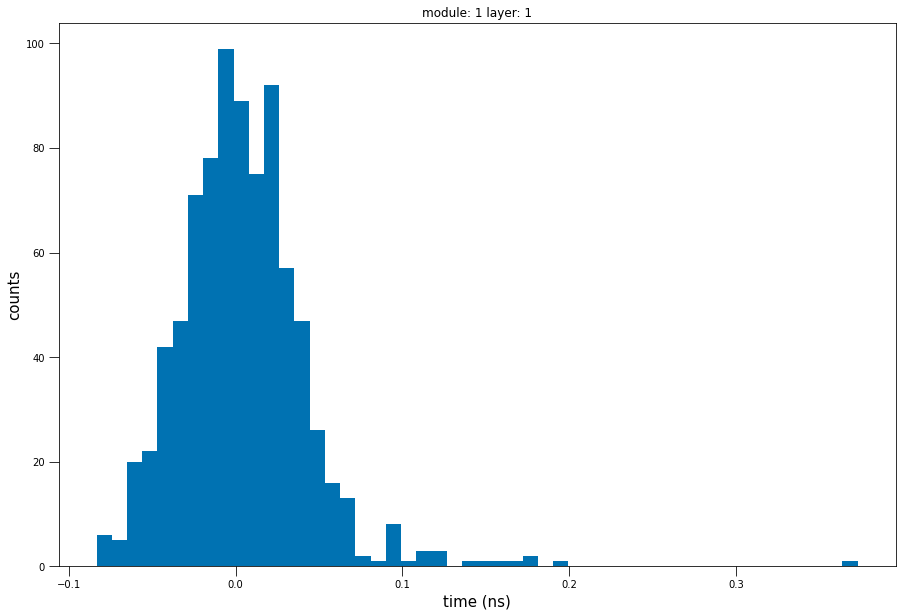

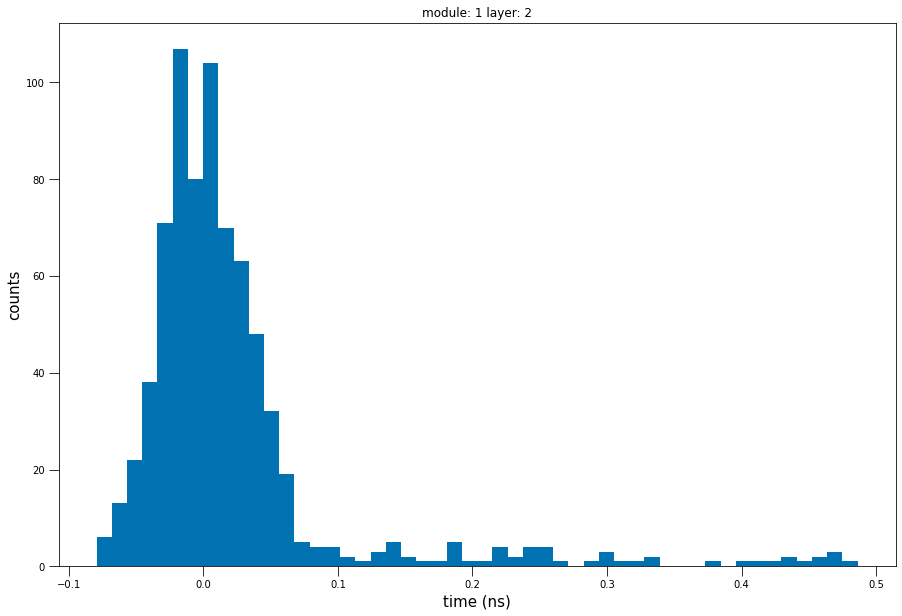

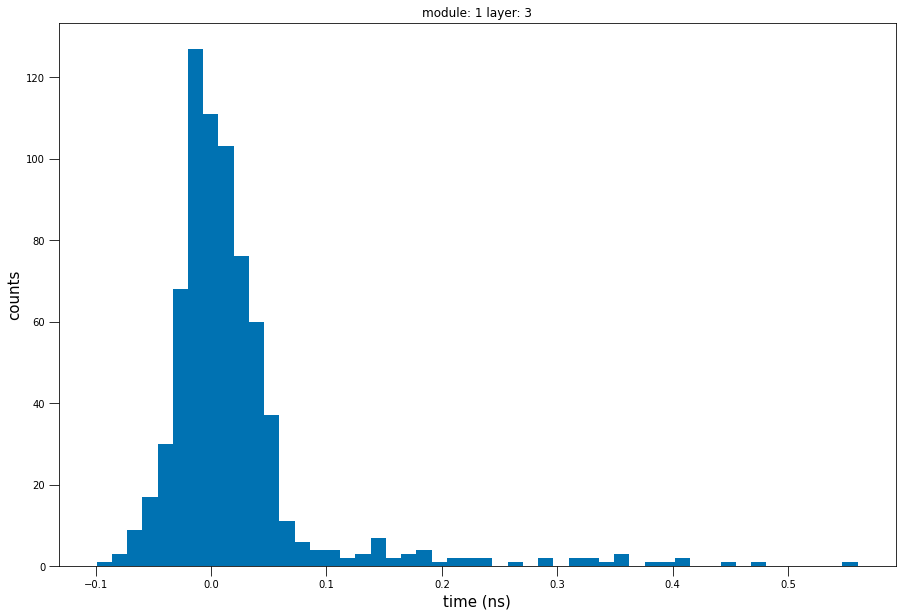

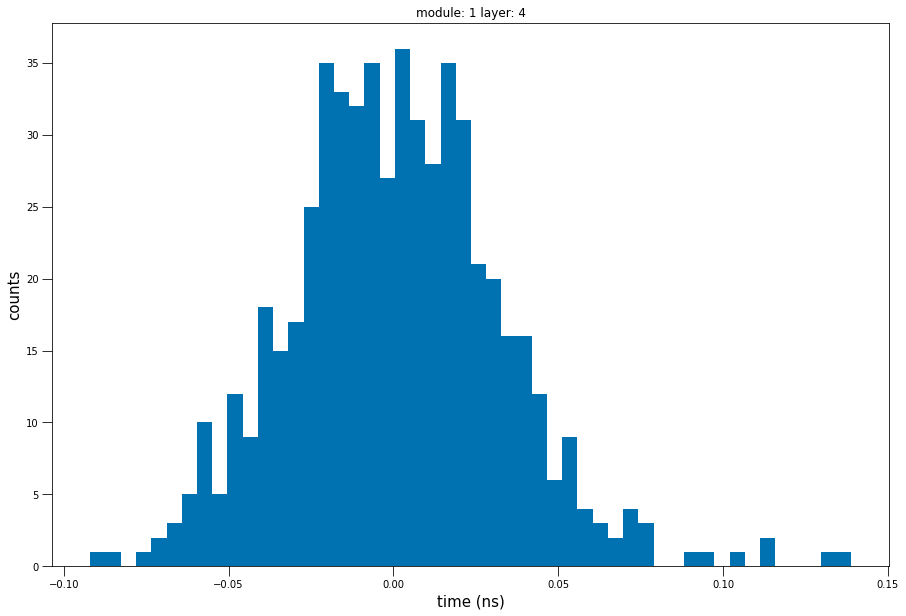

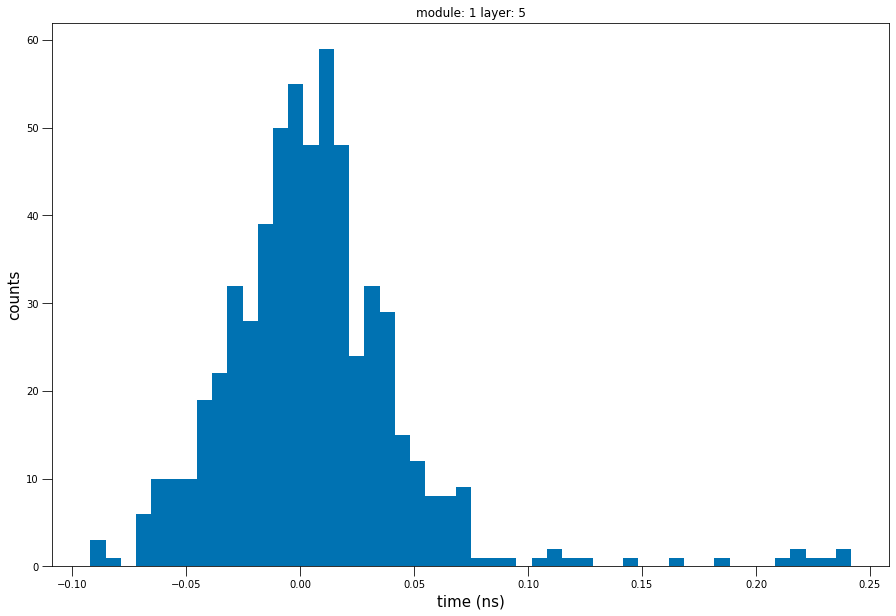

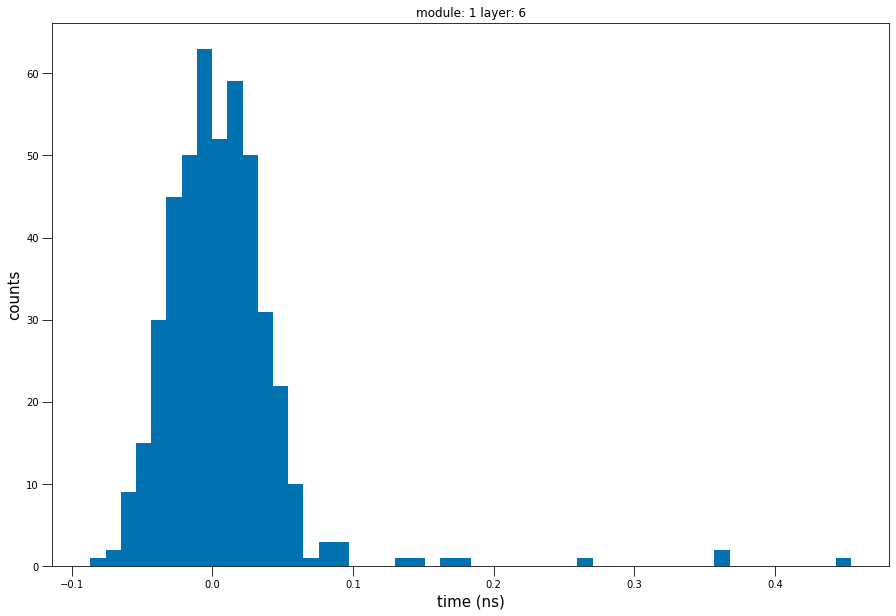

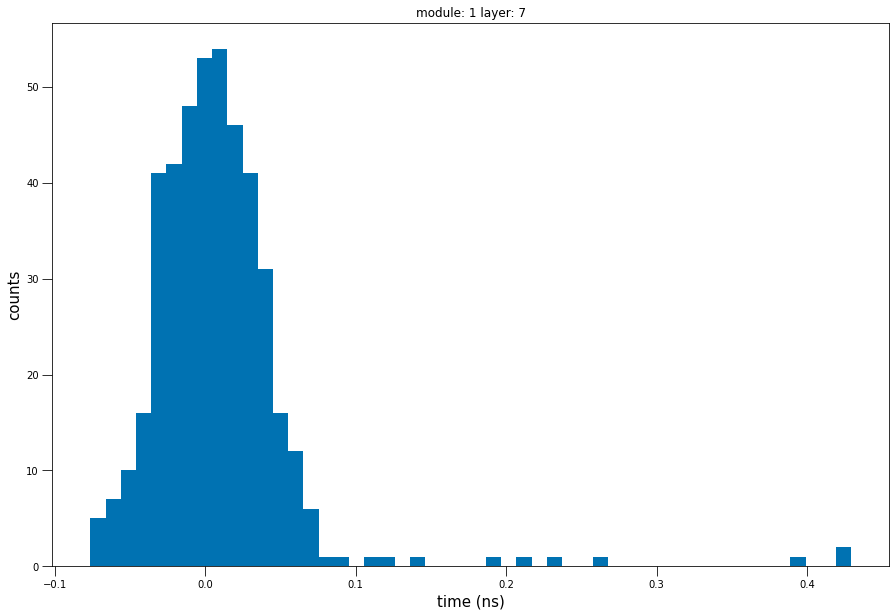

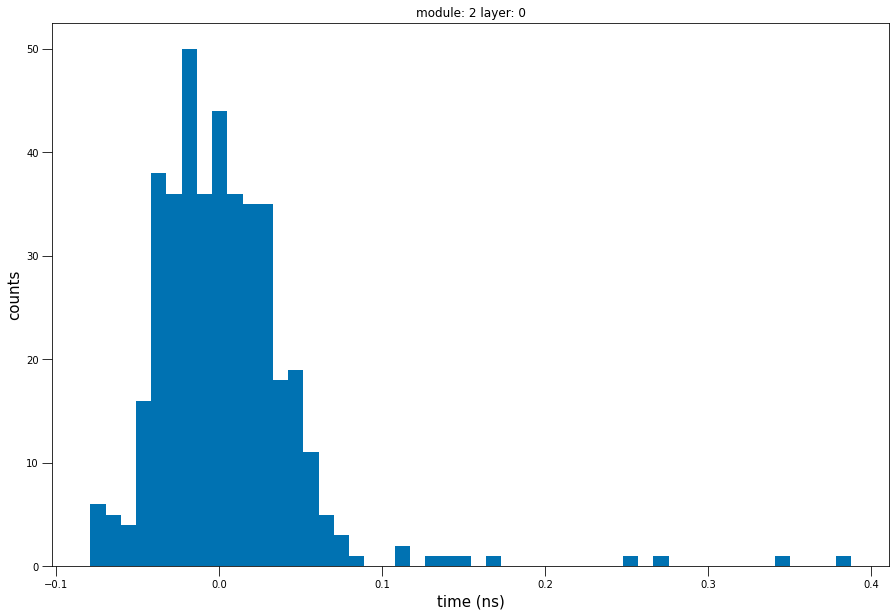

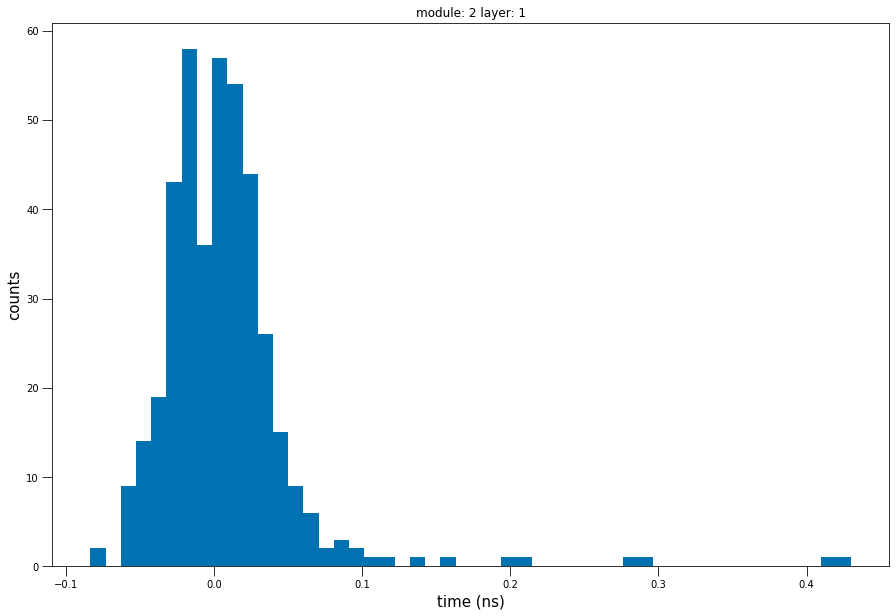

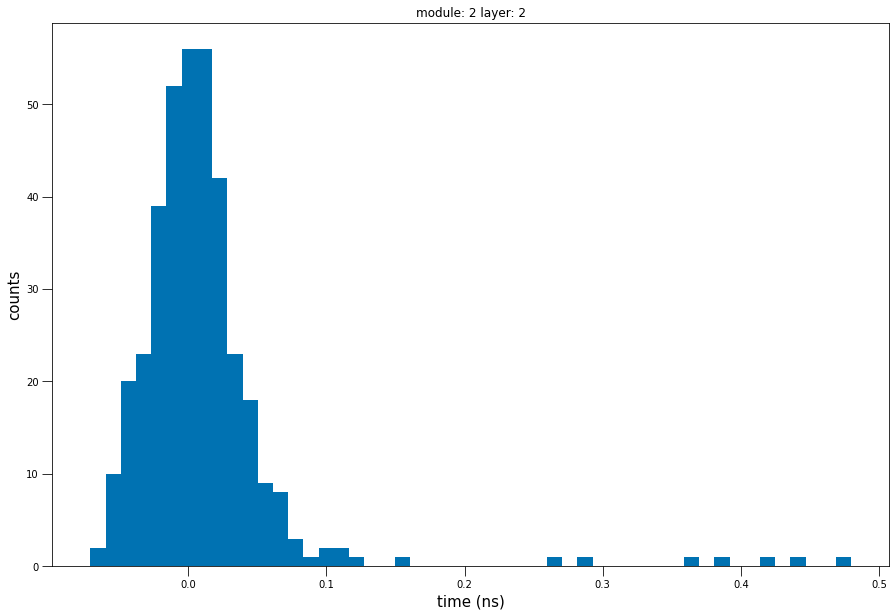

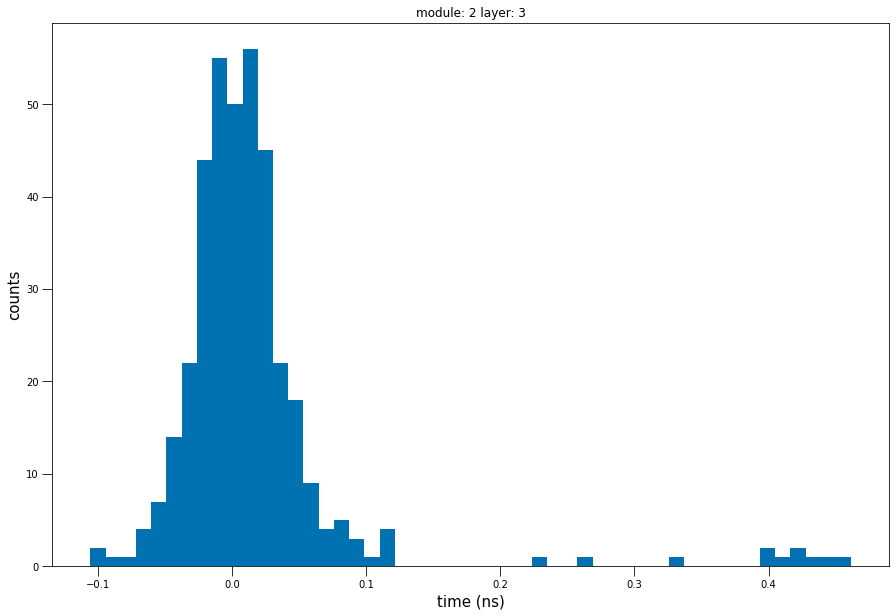

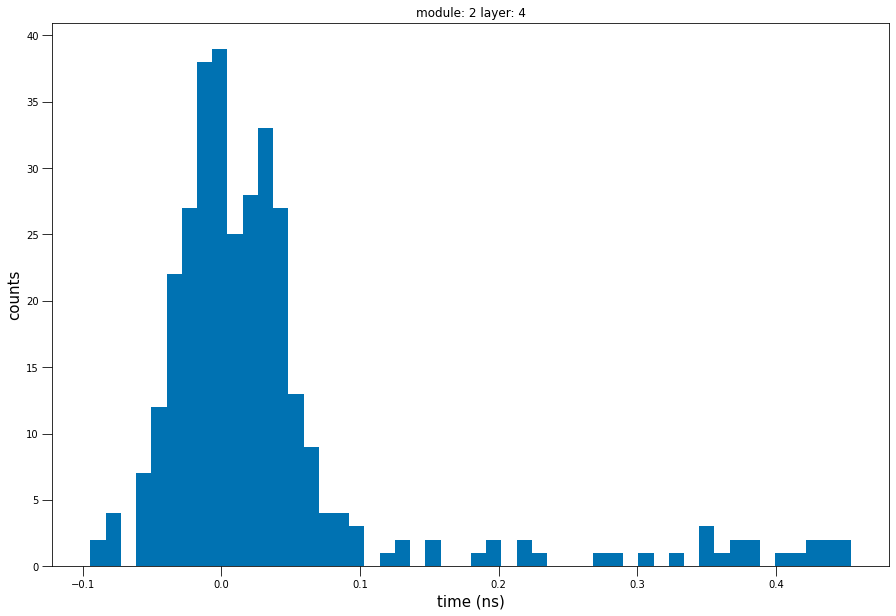

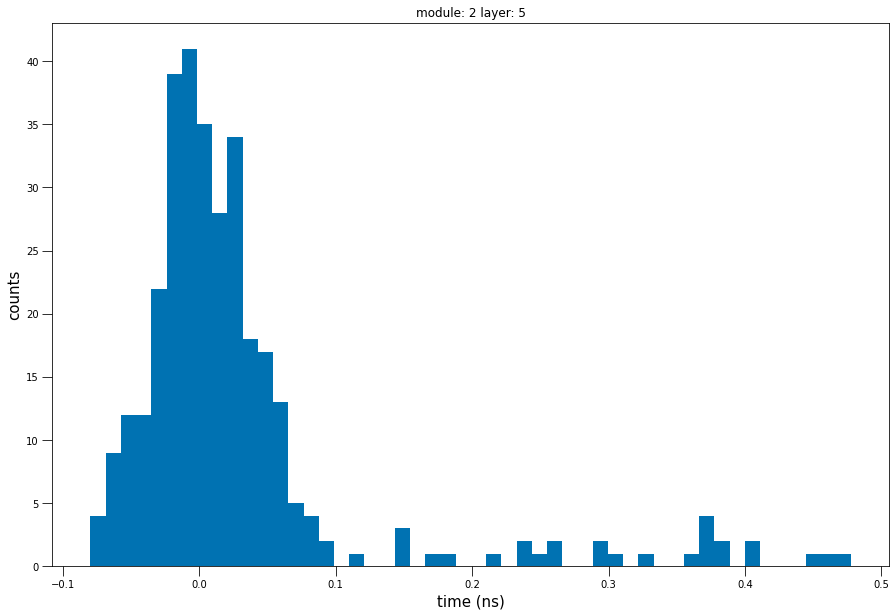

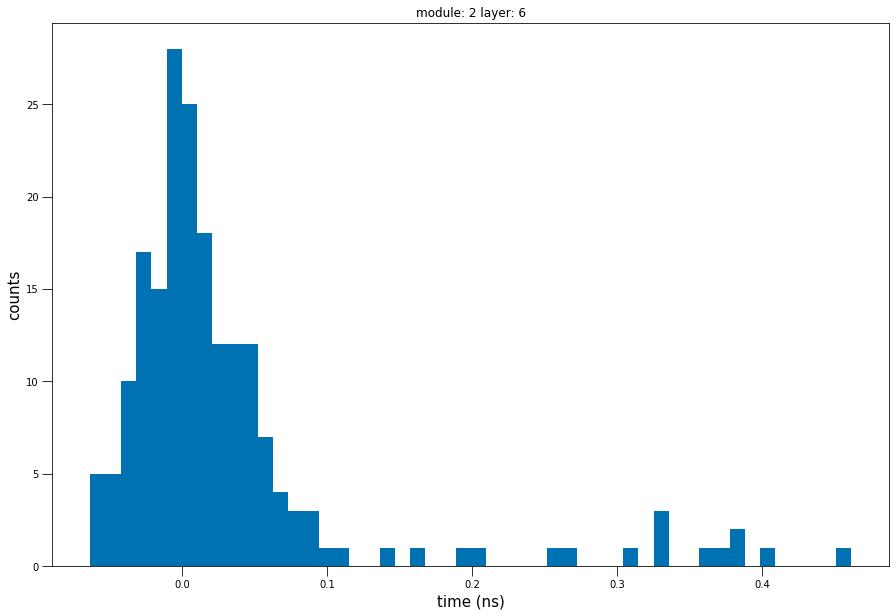

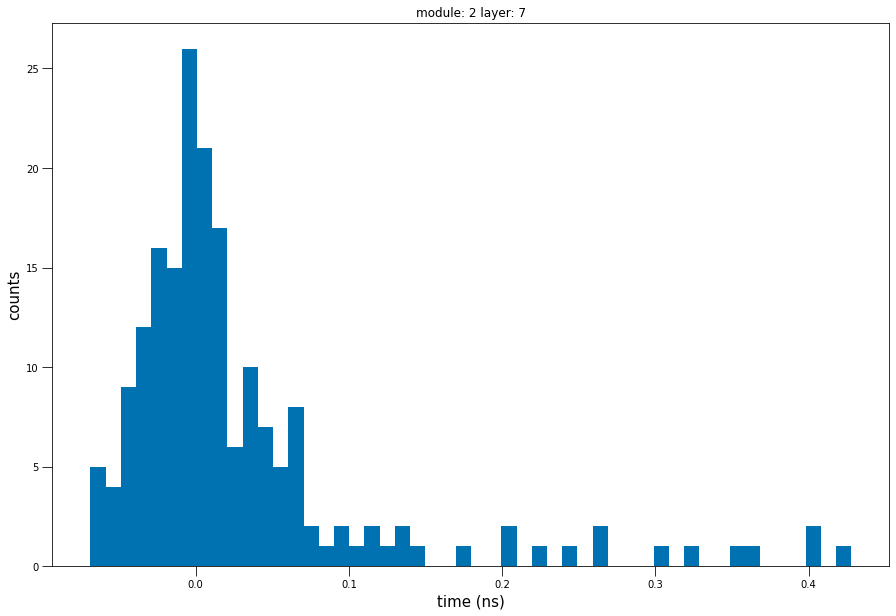

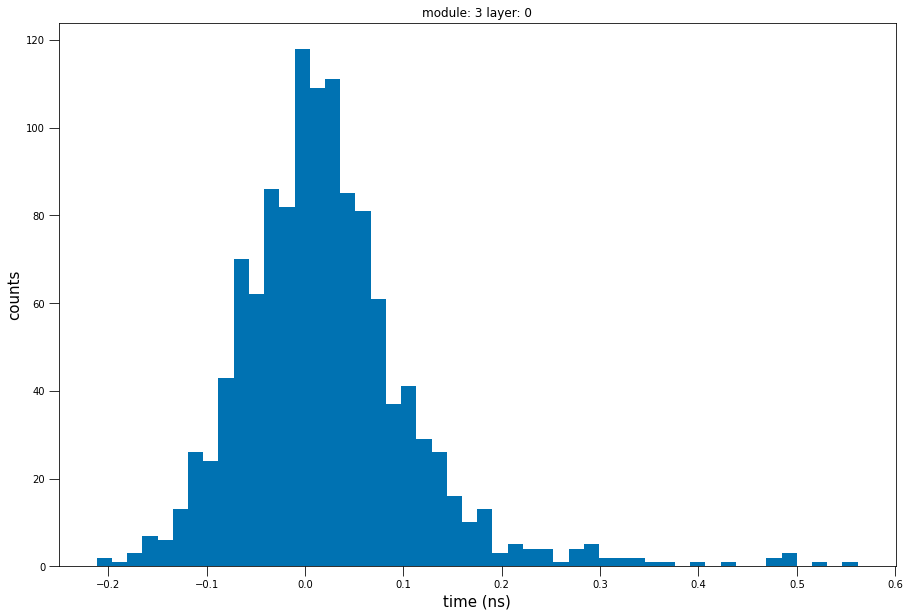

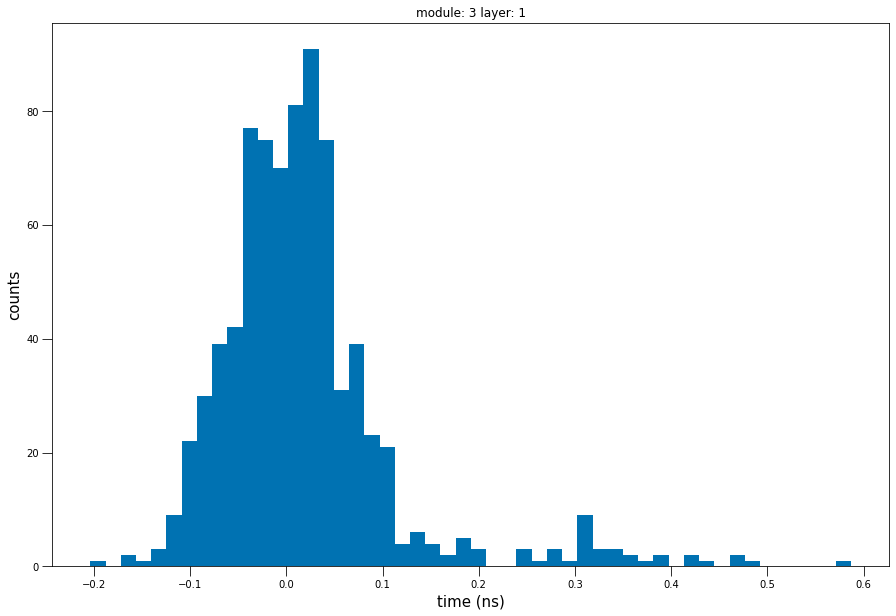

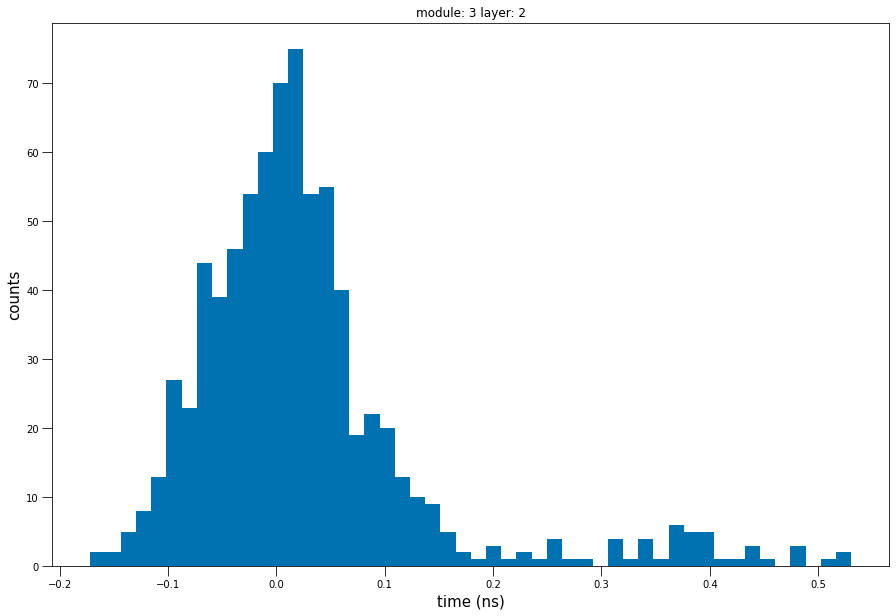

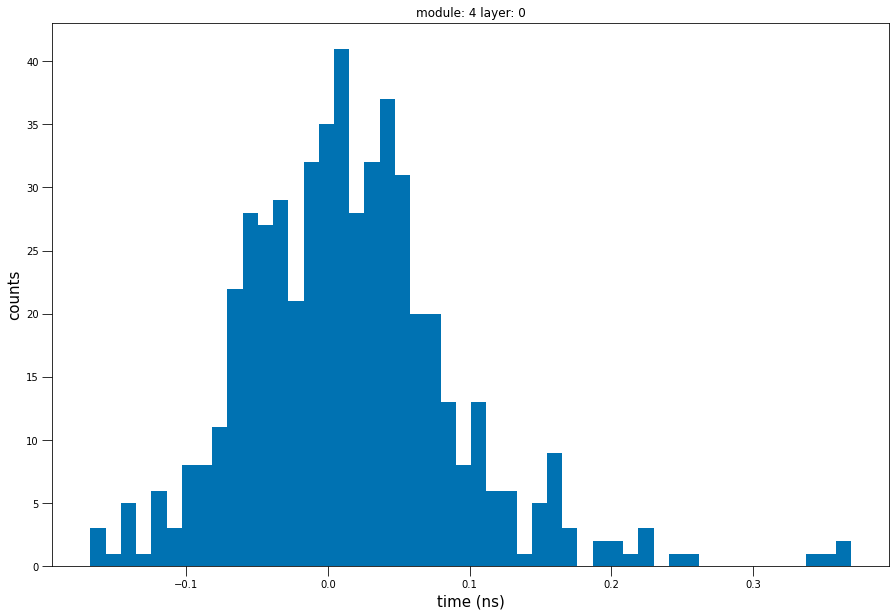

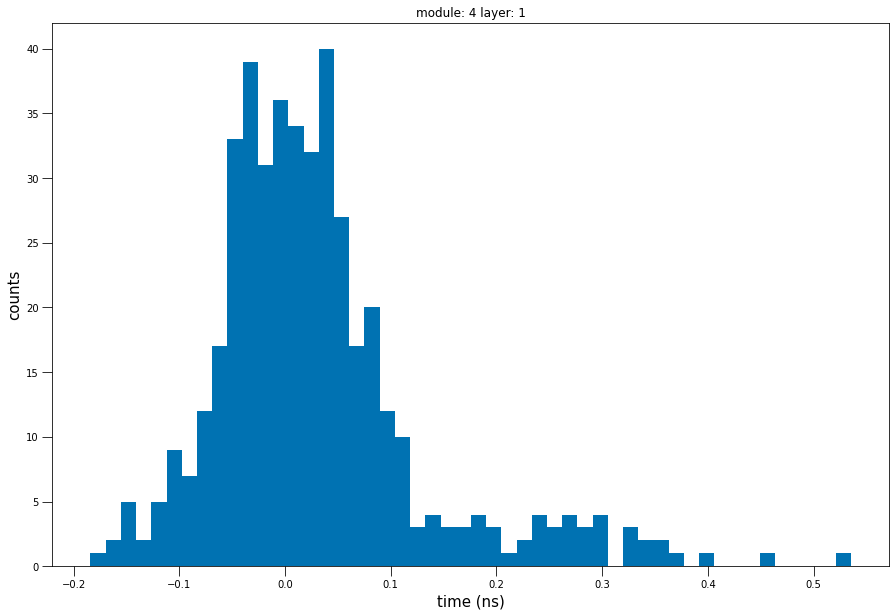

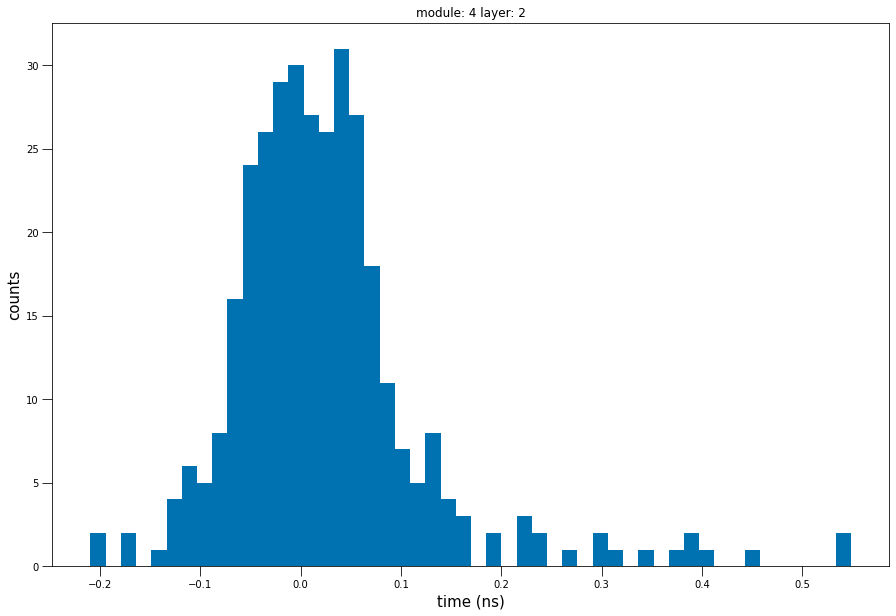

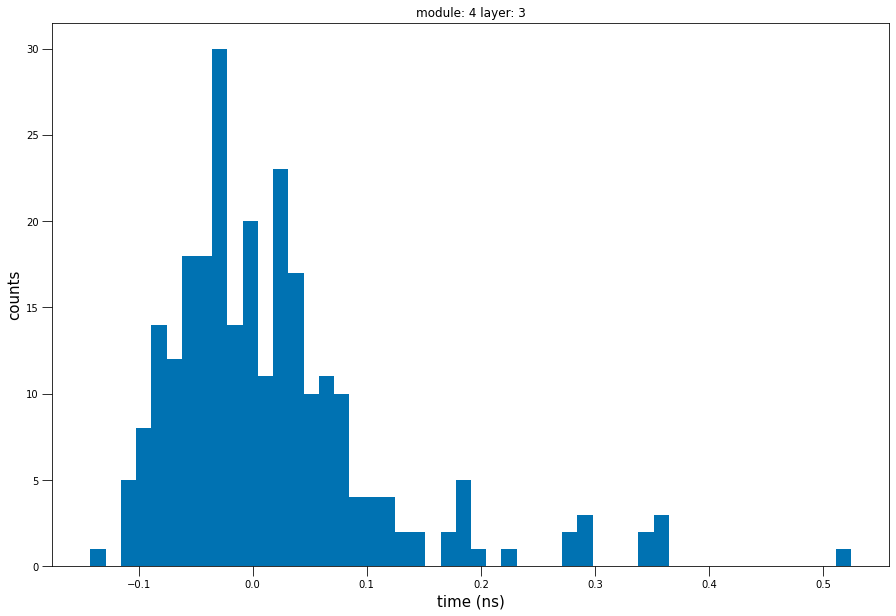

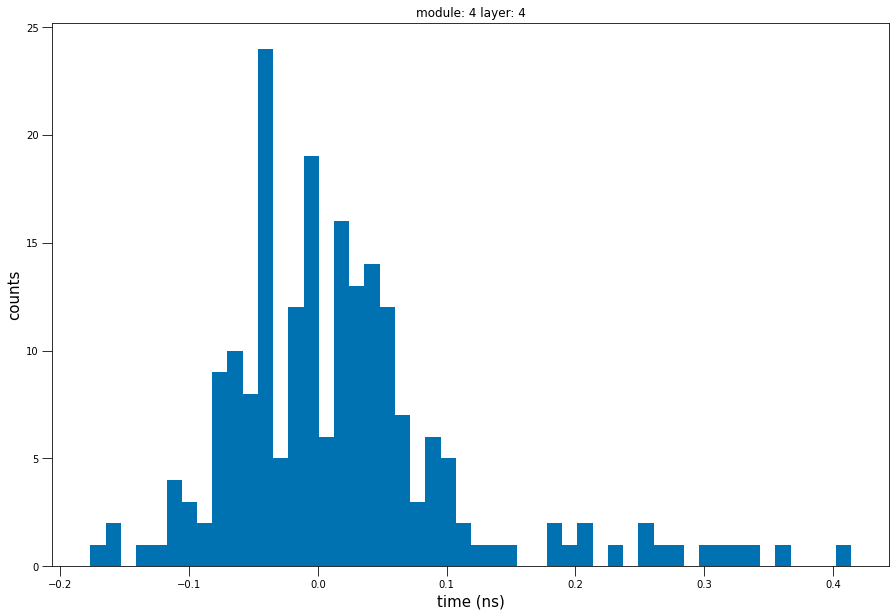

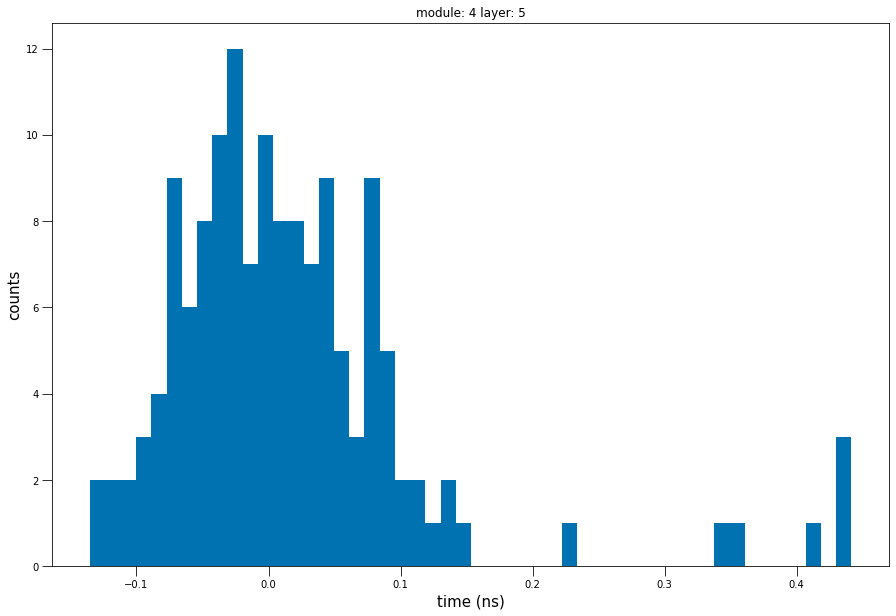

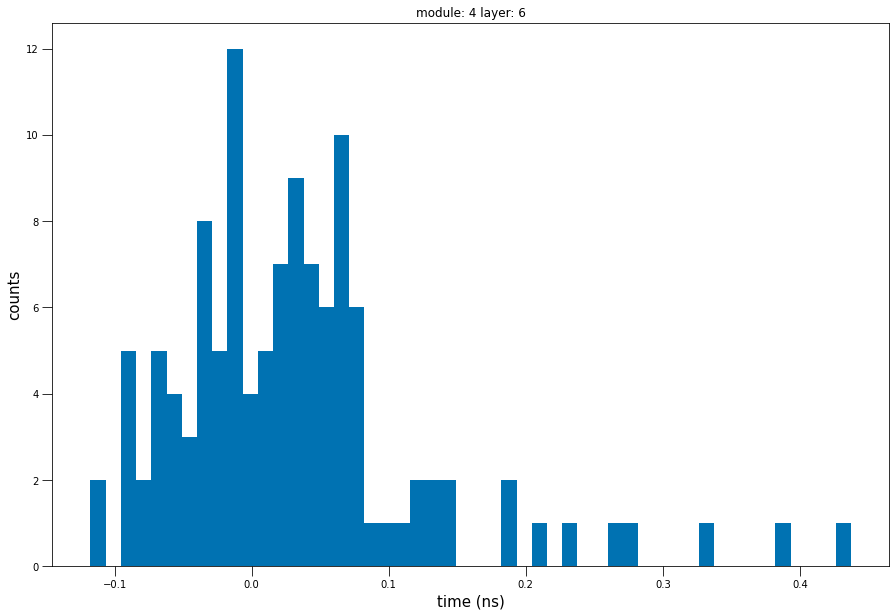

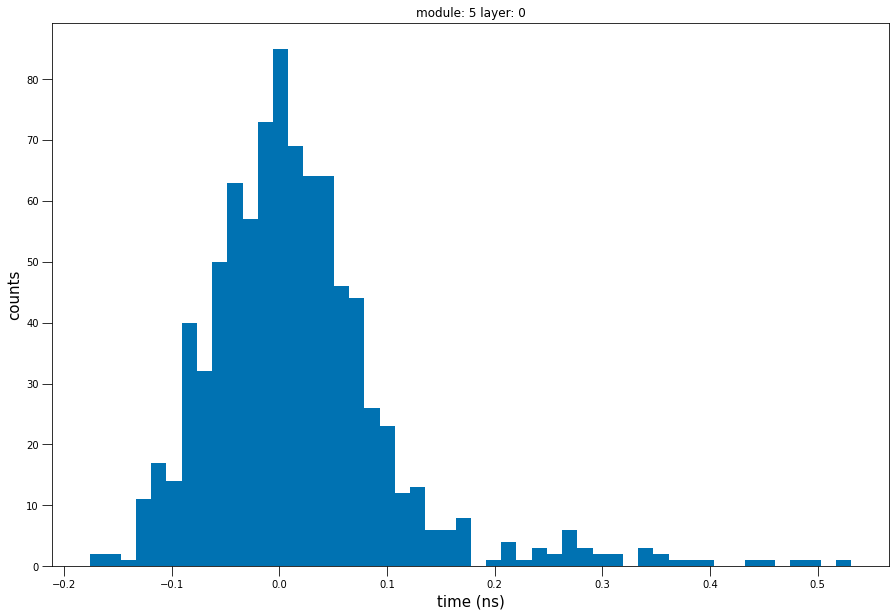

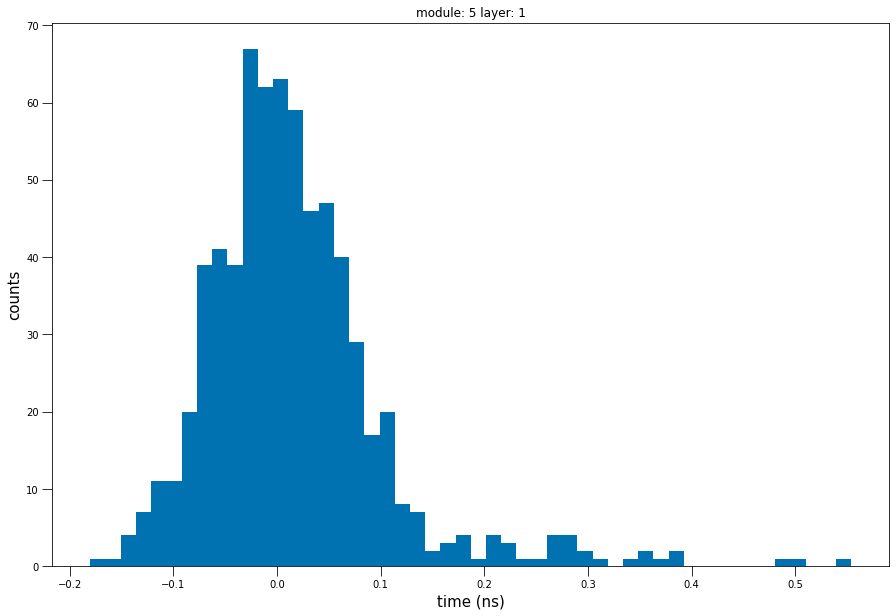

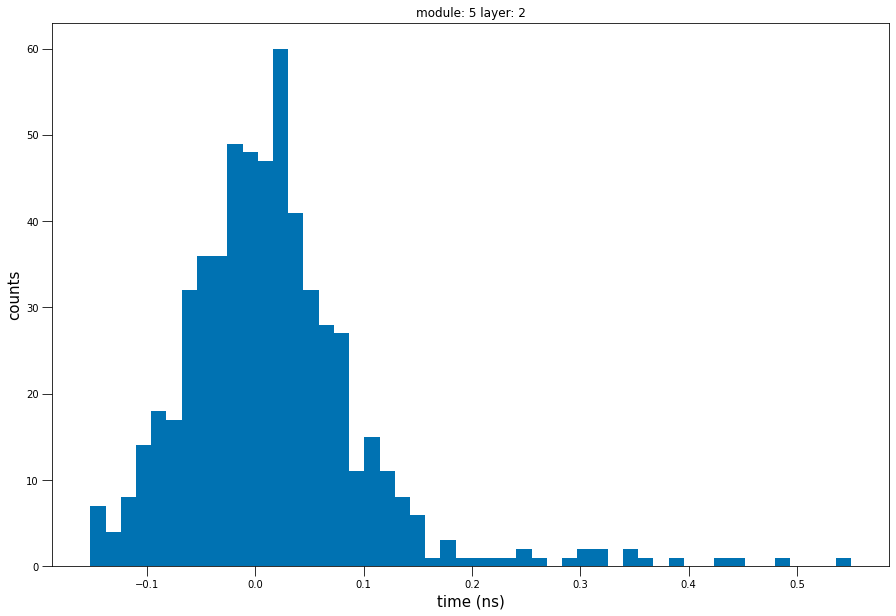

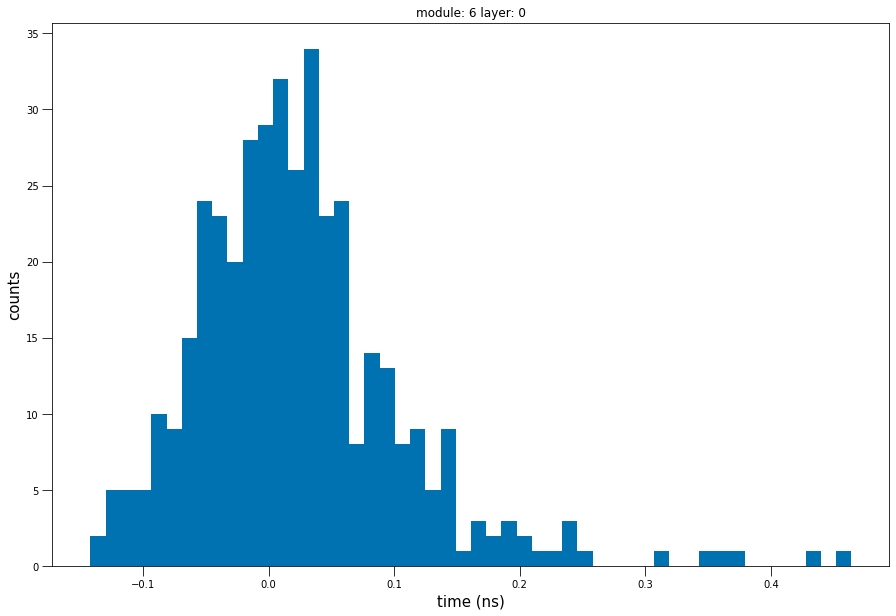

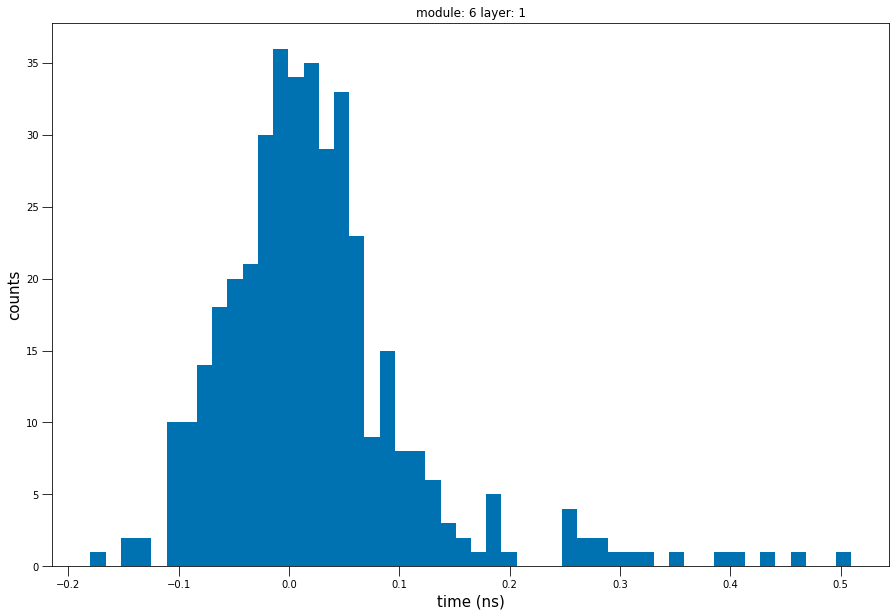

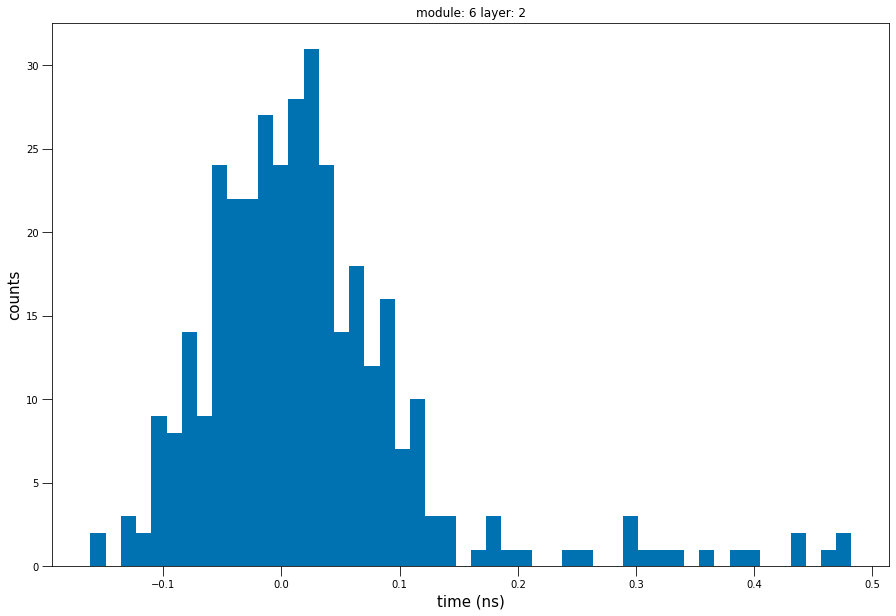

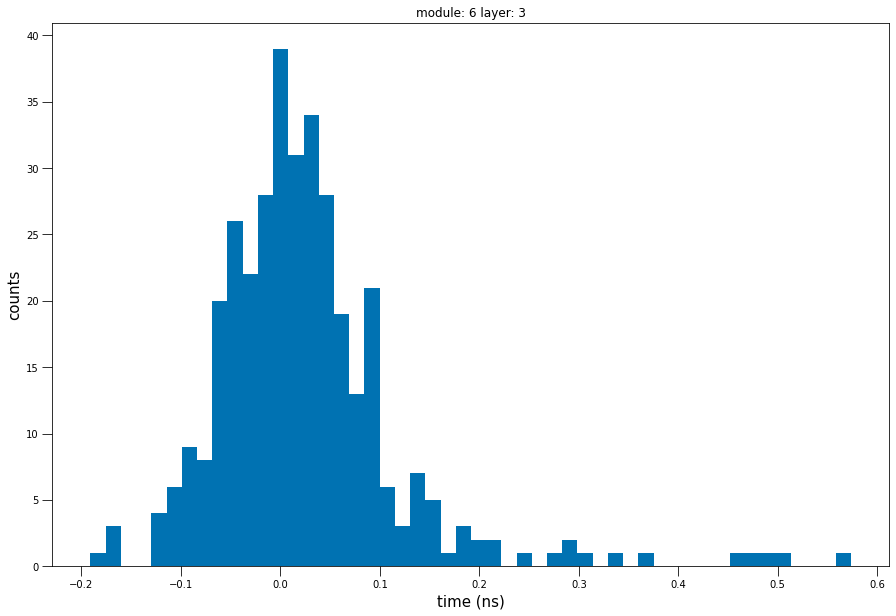

In [16]:
#Finding time distributions for every module-layer pair
c=299792458*1000*10**(-9) #speed of light in m/s times correction to mm/s times correction to mm/ns
for i in range(6):
    inMod=(tree["module"].array()==(i+1))
    for j in range(layerPerModule[i+1]):
        inLayer=(tree["layer"].array()==j)
        inside=inLayer & inMod
        time=tree["t"].array()[inside]-np.sqrt(tree["x"].array()[inside]**2+tree["y"].array()[inside]**2+tree["z"].array()[inside]**2)/c
        if i <=1:
            time=time+norm.rvs(size=np.sum(inside), scale=0.03) #adding 30 ps time resolution to vertex hits
        else:
            time=time+norm.rvs(size=np.sum(inside), scale=0.06) #adding 60 ps time resolution to inner detector and outer detector hits
        plot1DHistogram(time, bins=50, label=("module: " +str(i+1) + " layer: " + str(j) +";time (ns);counts"))

In [52]:
vertStartTime=norm.ppf(q=np.linspace(0,0.05,10),scale=0.03)
vertEndTime=norm.ppf(q=np.linspace(0.95,1,10),scale=0.03)
innerOuterStartTime=norm.ppf(q=np.linspace(0,0.05,10),scale=0.06)
innerOuterEndTime=norm.ppf(q=np.linspace(0.95,1,10),scale=0.06)

In [53]:
startTime=[]
endTime=[]
minCount=[]
for i in range(6):
    print(i)
    startTime.append([])
    endTime.append([])
    minCount.append([])
    for j in range(layerPerModule[i+1]):
        print(j)
        minimum=math.inf
        minStart=0
        minEnd=1
        inside=((treeBIB["module"].array()==(i+1)) & (treeBIB["layer"].array()==(j)))
        if i <=1:
            for startNum, start in enumerate(vertStartTime):
                countInside=np.sum((treeBIB["t"].array()[inside] >= start) & (treeBIB["t"].array()[inside] <= vertEndTime[startNum]))
                if minimum > countInside:
                    minimum=countInside
                    minStart=start
                    minEnd=vertEndTime[startNum]
        else:
            for startNum, start in enumerate(innerOuterStartTime):
                countInside=np.sum((treeBIB["t"].array()[inside] >= start) & (treeBIB["t"].array()[inside] <= innerOuterEndTime[startNum]))
                if minimum > countInside:
                    minimum=countInside
                    minStart=start
                    minEnd=innerOuterEndTime[startNum]
        
        startTime[i].append(minStart)
        endTime[i].append(minEnd)
        minCount[i].append(minimum)
        

0
0
1
2
3
4
5
6
7
1
0
1
2
3
4
5
6
7
2
0
1
2
3
0
1
2
3
4
5
6
4
0
1
2
5
0
1
2
3


In [55]:
sumation=0
for i in minCount:
    for j in i:
        sumation+=j
print(sumation)
print(1-sumation/len(treeBIB["x"].array()))

6590803
0.5773682290167089
